### Importy

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cmdstanpy
from cmdstanpy import CmdStanModel
import arviz as az
import scipy.stats as stats
# warnings.filterwarnings('ignore')


### Wczytanie danych i wybór potrzebnych wartości

In [45]:
df_weather = pd.read_csv("data/weather.csv")
df_weather = df_weather[['timestamp', 'site_id', 'airTemperature' ]]
df_weather['timestamp'] = pd.to_datetime(df_weather['timestamp'])
df_weather.describe()
df_weather

,timestamp,site_id,airTemperature
0,2016-01-01 00:00:00,Panther,19.4
1,2016-01-01 01:00:00,Panther,21.1
2,2016-01-01 02:00:00,Panther,21.1
3,2016-01-01 03:00:00,Panther,20.6
4,2016-01-01 04:00:00,Panther,21.1
...,...,...,...
331161,2017-12-31 19:00:00,Mouse,8.5
331162,2017-12-31 20:00:00,Mouse,8.5
331163,2017-12-31 21:00:00,Mouse,8.2
331164,2017-12-31 22:00:00,Mouse,7.5


In [46]:
df_meta = pd.read_csv("data/metadata.csv")

# Filtruj tylko wiersze, gdzie electricity == "Yes" i wybierz odpowiednie kolumny
df_meta = df_meta[['site_id', 'building_id', 'sqm', 'lat', 'lng', 'timezone', 'electricity', 'industry', 'yearbuilt', 'numberoffloors', 'occupants']][df_meta['electricity'] == "Yes"]
df_meta = df_meta.drop(columns=['electricity'])

# Grupowanie z odpowiednimi funkcjami agregującymi
df_grouped = df_meta.groupby(["site_id", "building_id"]).agg({
    'sqm': 'sum',  # Sumuj powierzchnię
    'lat': 'first',  # Weź pierwszą wartość (bez sumowania)
    'lng': 'first',  # Weź pierwszą wartość
    'timezone': 'first',  # Zachowaj tekst
    'industry': 'first',  # Zachowaj tekst
    'yearbuilt': 'first',  # Nie sumuj roku budowy
    'numberoffloors': 'first',  # Nie sumuj liczby pięter
    'occupants': 'first',  # Nie sumuj liczby osób
}).reset_index()  # Reset index, jeśli chcesz mieć site_id i building_id jako kolumny

df_grouped

,site_id,building_id,sqm,lat,lng,timezone,industry,yearbuilt,numberoffloors,occupants
0,Bear,Bear_assembly_Angel,22117.0,37.871903,-122.260729,US/Pacific,None,1933.0,6.0,NaN
1,Bear,Bear_assembly_Beatrice,2802.0,37.871903,-122.260729,US/Pacific,None,1958.0,4.0,NaN
2,Bear,Bear_assembly_Danial,7680.3,37.871903,-122.260729,US/Pacific,None,2016.0,4.0,NaN
3,Bear,Bear_assembly_Diana,121.2,37.871903,-122.260729,US/Pacific,None,1995.0,1.0,NaN
4,Bear,Bear_assembly_Genia,24256.1,37.871903,-122.260729,US/Pacific,None,1923.0,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...
1573,Wolf,Wolf_public_Norma,23500.0,53.349800,6.260300,Europe/Dublin,Education,NaN,NaN,NaN
1574,Wolf,Wolf_retail_Harriett,4108.0,53.349800,6.260300,Europe/Dublin,Education,NaN,NaN,NaN
1575,Wolf,Wolf_retail_Marcella,363.0,53.349800,6.260300,Europe/Dublin,Education,NaN,1.0,NaN
1576,Wolf,Wolf_retail_Toshia,4209.0,53.349800,6.260300,Europe/Dublin,Education,NaN,2.0,NaN


In [ ]:
df_electricity = pd.read_csv("data/electricity_cleaned.csv")
df_electricity.head()

In [ ]:
df_electricity_long = df_electricity.melt(
    id_vars=['timestamp'],  # Kolumna z czasem
    var_name='building_id',  # Nazwy kolumn staną się wartościami w tej kolumnie
    value_name='energy_consumption'  # Wartości z kolumn trafią tutaj
)

# Połączenie z metadanymi
df_merged = pd.merge(
    df_electricity_long,
    df_meta,
    on='building_id',
    how='outer'  # Zachowaj wszystkie wiersze z df_electricity_long
)

# Usunięcie wierszy z brakującymi wartościami energy_consumption
df_merged = df_merged.dropna(subset=['energy_consumption'])

# Reset indeksu (opcjonalne)
df_merged = df_merged.reset_index(drop=True)

# Wynik
df_merged.head()

,timestamp,building_id,energy_consumption,site_id,sqm,lat,lng,timezone,industry,yearbuilt,numberoffloors,occupants
0,2016-01-01 00:00:00,Bear_assembly_Angel,237.85,Bear,22117.0,37.871903,-122.260729,US/Pacific,NaN,1933.0,6.0,NaN
1,2016-01-01 01:00:00,Bear_assembly_Angel,221.25,Bear,22117.0,37.871903,-122.260729,US/Pacific,NaN,1933.0,6.0,NaN
2,2016-01-01 02:00:00,Bear_assembly_Angel,222.50,Bear,22117.0,37.871903,-122.260729,US/Pacific,NaN,1933.0,6.0,NaN
3,2016-01-01 03:00:00,Bear_assembly_Angel,221.40,Bear,22117.0,37.871903,-122.260729,US/Pacific,NaN,1933.0,6.0,NaN
4,2016-01-01 04:00:00,Bear_assembly_Angel,224.25,Bear,22117.0,37.871903,-122.260729,US/Pacific,NaN,1933.0,6.0,NaN


In [ ]:
df_merged.head()

,timestamp,building_id,energy_consumption,site_id,sqm,lat,lng,timezone,industry,yearbuilt,numberoffloors,occupants
0,2016-01-01 00:00:00,Bear_assembly_Angel,237.85,Bear,22117.0,37.871903,-122.260729,US/Pacific,NaN,1933.0,6.0,NaN
1,2016-01-01 01:00:00,Bear_assembly_Angel,221.25,Bear,22117.0,37.871903,-122.260729,US/Pacific,NaN,1933.0,6.0,NaN
2,2016-01-01 02:00:00,Bear_assembly_Angel,222.50,Bear,22117.0,37.871903,-122.260729,US/Pacific,NaN,1933.0,6.0,NaN
3,2016-01-01 03:00:00,Bear_assembly_Angel,221.40,Bear,22117.0,37.871903,-122.260729,US/Pacific,NaN,1933.0,6.0,NaN
4,2016-01-01 04:00:00,Bear_assembly_Angel,224.25,Bear,22117.0,37.871903,-122.260729,US/Pacific,NaN,1933.0,6.0,NaN


In [ ]:
df_merged['timestamp'] = pd.to_datetime(df_merged['timestamp'])
df_weather['timestamp'] = pd.to_datetime(df_weather['timestamp'])

# Połączenie danych
df_final = pd.merge(
    df_merged,
    df_weather,
    on=['timestamp', 'site_id'],
    how='left',
)

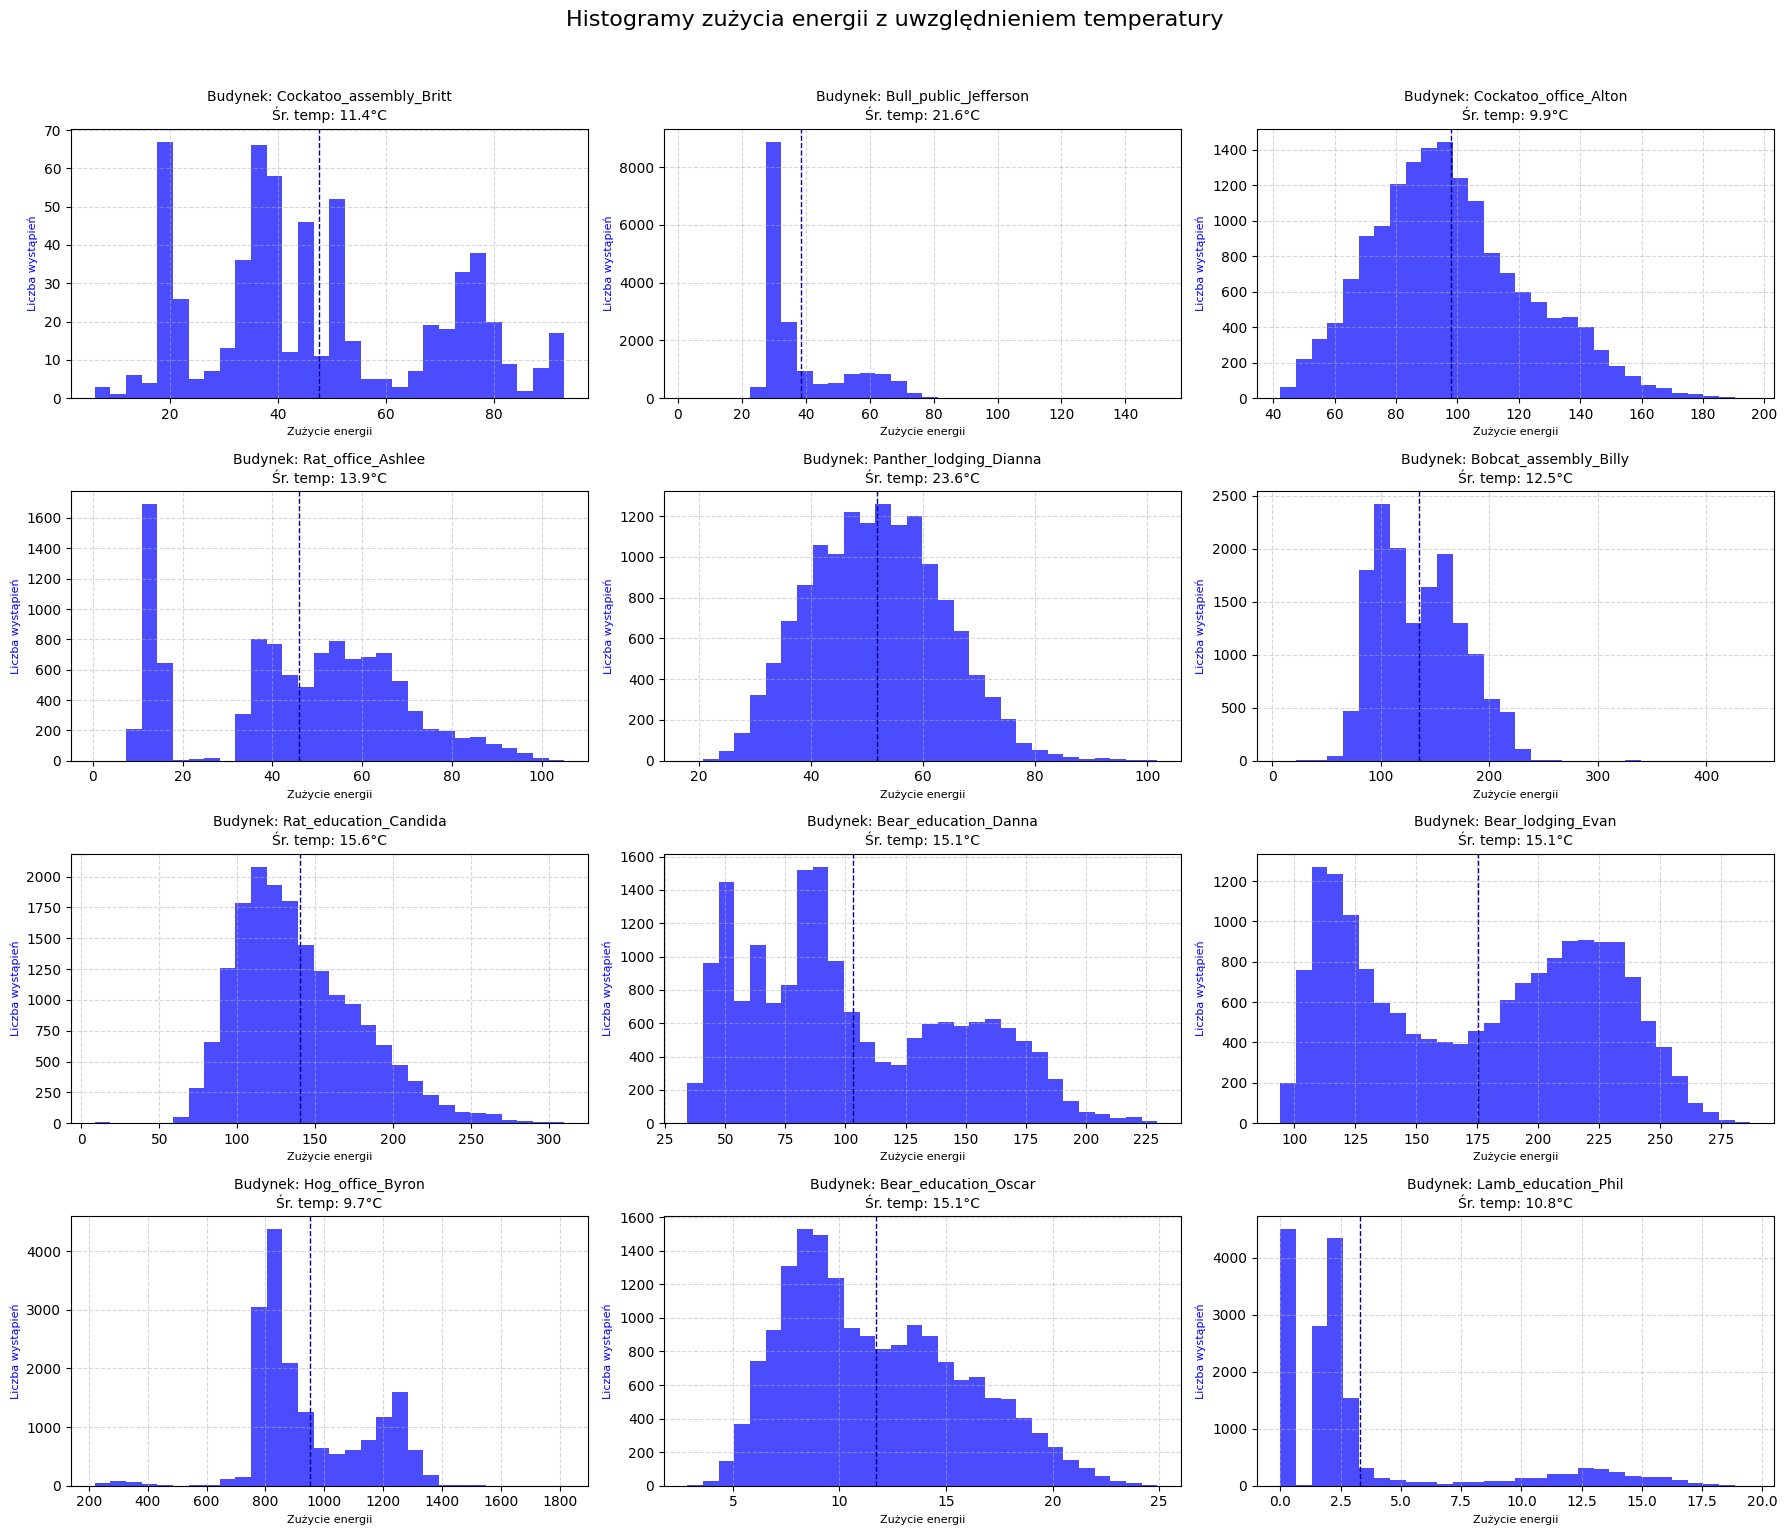

In [ ]:
# 2. Wybór 12 losowych budynków
unique_buildings = df_final['building_id'].unique()
random_buildings = np.random.choice(unique_buildings, size=12, replace=False)

# 3. Przygotowanie wykresów
fig, axes = plt.subplots(4, 3, figsize=(18, 15))
fig.suptitle('Histogramy zużycia energii z uwzględnieniem temperatury', fontsize=16, y=1.02)

for i, building_id in enumerate(random_buildings):
    # Dane dla wybranego budynku
    building_data = df_final[df_final['building_id'] == building_id]
    
    # Pozycja subplotu
    row, col = i // 3, i % 3
    ax = axes[row, col]
    
    # Histogram zużycia energii
    ax.hist(building_data['energy_consumption'], bins=30, color='blue', alpha=0.7)

    # Formatowanie
    ax.set_title(f'Budynek: {building_id}\nŚr. temp: {building_data["airTemperature"].mean():.1f}°C', fontsize=10)
    ax.set_xlabel('Zużycie energii', fontsize=8)
    ax.set_ylabel('Liczba wystąpień', fontsize=8, color='blue')
    ax.grid(True, linestyle='--', alpha=0.5)
    
    # Linie średnich
    ax.axvline(building_data['energy_consumption'].mean(), color='darkblue', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

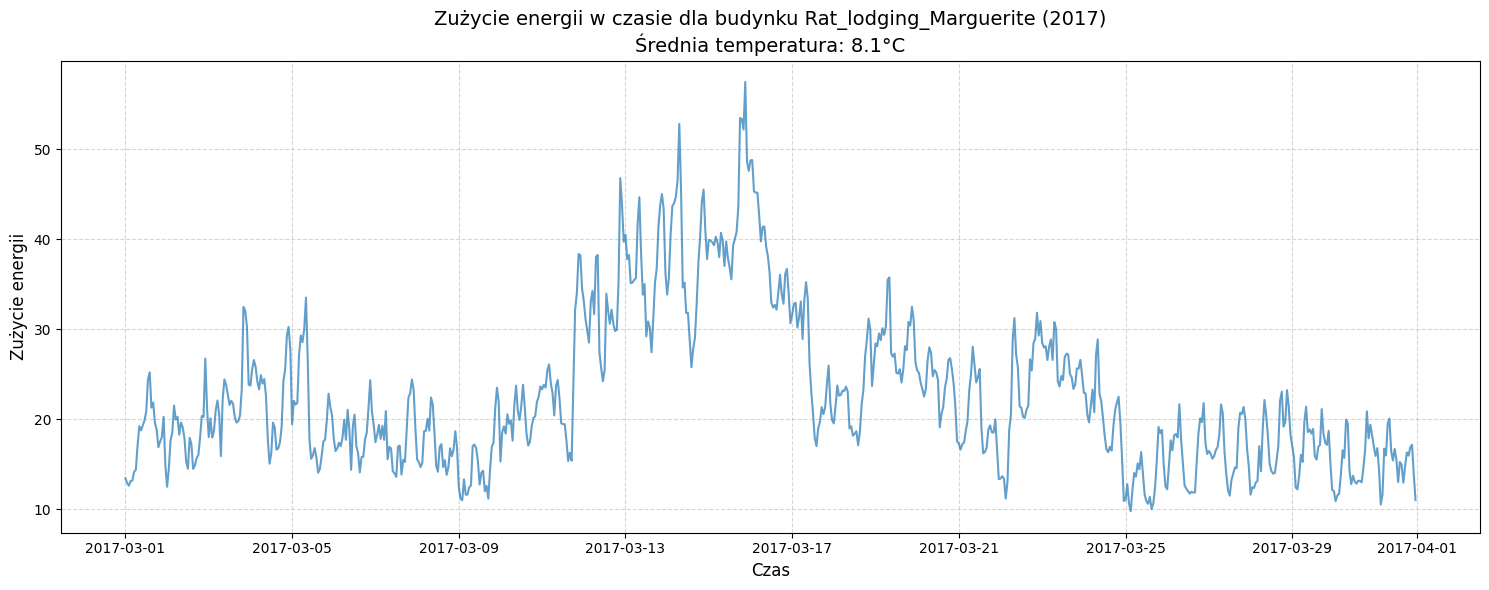

In [ ]:
# 1. Wybór losowego budynku
random_building = np.random.choice(df_final['building_id'].unique())

# 2. Filtrowanie danych dla wybranego budynku i roku 2017
building_data = df_final[(df_final['building_id'] == random_building) & 
                         (df_final['timestamp'].dt.year == 2017)& 
                         (df_final['timestamp'].dt.month == 3)].sort_values('timestamp')

# 3. Tworzenie wykresu scatter
plt.figure(figsize=(15, 6))
plt.plot(building_data['timestamp'], building_data['energy_consumption'], alpha=0.7)

# 4. Formatowanie wykresu
plt.title(f'Zużycie energii w czasie dla budynku {random_building} (2017)\n'
          f'Średnia temperatura: {building_data["airTemperature"].mean():.1f}°C', fontsize=14)
plt.xlabel('Czas', fontsize=12)
plt.ylabel('Zużycie energii', fontsize=12)


plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# building_data.to_csv('third_building_data.csv', index=False)

### Analiza i preprocessing

In [ ]:
df_final.describe()

,timestamp,energy_consumption,sqm,lat,lng,yearbuilt,numberoffloors,occupants,airTemperature
count,25212579,2.521258e+07,2.521258e+07,2.176336e+07,2.176336e+07,1.219226e+07,6.926062e+06,3.462585e+06,2.511925e+07
mean,2017-01-05 02:23:47.485733120,1.449146e+02,8.411533e+03,4.025139e+01,-7.373975e+01,1.966742e+03,3.673795e+00,2.804720e+02,1.568691e+01
min,2016-01-01 00:00:00,1.000000e-04,2.630000e+01,2.851769e+01,-1.222607e+02,1.900000e+03,1.000000e+00,0.000000e+00,-2.890000e+01
25%,2016-07-10 08:00:00,1.937500e+01,2.053200e+03,3.342443e+01,-9.774310e+01,1.945000e+03,1.000000e+00,3.400000e+01,8.900000e+00
50%,2017-01-06 02:00:00,5.957000e+01,5.261700e+03,3.890350e+01,-7.700535e+01,1.969000e+03,2.000000e+00,1.000000e+02,1.610000e+01
75%,2017-07-05 09:00:00,1.568667e+02,1.049800e+04,4.497878e+01,-7.648529e+01,1.991000e+03,5.000000e+00,3.330000e+02,2.330000e+01
max,2017-12-31 23:00:00,2.212280e+05,8.129010e+04,5.334980e+01,6.260300e+00,2.017000e+03,2.600000e+01,2.380000e+03,4.830000e+01
std,NaN,2.688494e+02,1.020827e+04,7.290676e+00,3.780838e+01,3.092296e+01,3.219477e+00,4.155114e+02,1.026259e+01


In [ ]:
df_all_test = df_final.copy()
df_all_test = df_all_test.dropna()

In [ ]:
# Creating models

df_subset = df_all_test[df_all_test['building_id'] == 'Shrew_office_Sherill'].copy()
# df_subset = df_final[:1000]
# df_subset['occupants'] = df_subset['occupants'].fillna(0)
N = len(df_subset)

model_prior_all = CmdStanModel(stan_file='prior_all.stan')

temp = df_subset['airTemperature']
sqm	= df_subset['sqm']
lat = df_subset['lat']
lng = df_subset['lng']
yearbuilt = df_subset['yearbuilt']
numberoffloors = df_subset['numberoffloors']
occupants = df_subset['occupants']
df_subset['hour'] = df_subset['timestamp'].dt.hour
df_subset['month'] = df_subset['timestamp'].dt.month
df_subset['day_of_week'] = df_subset['timestamp'].dt.dayofweek

# Setting data
data = {'N': N, 'temp': temp, 'sqm': sqm, 'lat': lat, 'lng': lng,
        'yearbuilt': yearbuilt, 'numberoffloors': numberoffloors, 
        'occupants': occupants,
        'hour': df_subset['hour'], 'month': df_subset['month'],
        'day_of_week': df_subset['day_of_week']}

# Sampling z priora
prior_all = model_prior_all.sample(
    data=data,
    iter_sampling=1000,
    iter_warmup=1,
    chains=1,
    fixed_param=True,
    seed=29042020,
    refresh=100,
)

# Odczyt wyników
prior_all_df = prior_all.draws_pd()
prior_all_df.head()

19:38:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

19:38:35 - cmdstanpy - INFO - CmdStan done processing.


,chain__,iter__,draw__,lp__,accept_stat__,y_sim[1],y_sim[2],y_sim[3],y_sim[4],y_sim[5],...,y_sim[9351],y_sim[9352],y_sim[9353],y_sim[9354],y_sim[9355],y_sim[9356],y_sim[9357],y_sim[9358],y_sim[9359],y_sim[9360]
0,1.0,1.0,1.0,0.0,0.0,13.92660,3.6888,5.97838,6.78470,2.39626,...,18.36080,14.39590,7.47809,6.881460,74.181300,59.78050,15.76990,36.646800,6.60613,5.428050
1,1.0,2.0,2.0,0.0,0.0,22.61480,16.5528,14.94350,25.84890,5.41863,...,28.72010,34.54940,50.31580,12.254400,0.747985,85.40960,1.80141,23.885700,80.07610,45.718900
2,1.0,3.0,3.0,0.0,0.0,13.28510,13.3991,12.83490,24.42330,4.04291,...,4.43634,12.71260,4.24267,61.839100,34.775600,9.70426,47.57400,0.928207,59.38250,12.166900
3,1.0,4.0,4.0,0.0,0.0,26.42820,15.0666,42.34140,4.18262,2.84178,...,40.33740,16.26350,2.02795,0.798928,14.223300,47.72750,32.84180,14.064200,11.62810,0.604177
4,1.0,5.0,5.0,0.0,0.0,4.48313,19.9757,14.88260,4.85369,21.31470,...,7.03700,3.69151,1.60726,0.982171,17.891500,2.20062,90.13260,26.746000,5.91532,11.698900


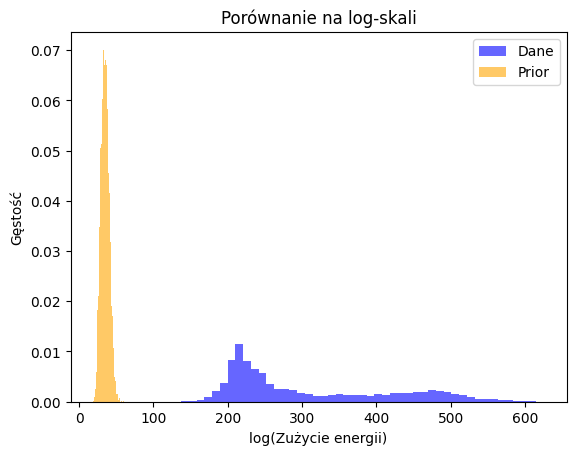

In [ ]:
prior_all_samples = prior_all.y_sim.mean(axis=0)

plt.hist(df_subset["energy_consumption"], bins=50, alpha=0.6, label="Dane", color='blue', density=True)
plt.hist(prior_all_samples, bins=50, alpha=0.6, label="Prior", color='orange', density=True)
plt.legend()
plt.xlabel("log(Zużycie energii)")
plt.ylabel("Gęstość")
plt.title("Porównanie na log-skali")
plt.show()

In [ ]:
y = df_subset['energy_consumption']

model_posterior_all = CmdStanModel(stan_file='posterior_all.stan')

# Setting data
data = {'N': N, 'temp': temp, 'sqm': sqm, 'lat': lat, 'lng': lng,
        'yearbuilt': yearbuilt, 'numberoffloors': numberoffloors, 
        'occupants': occupants,
        'hour': df_subset['hour'], 'month': df_subset['month'],
        'day_of_week': df_subset['day_of_week'],
        'y': y}

# Sampling z priora
posterior_all = model_posterior_all.sample(
    data=data,
    iter_sampling=1000,
    iter_warmup=1,
    chains=1,
    fixed_param=True,
    seed=29042020,
    refresh=100,
)

# Odczyt wyników
posterior_all_df = posterior_all.draws_pd()
posterior_all_df.head()

19:38:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

19:38:58 - cmdstanpy - INFO - CmdStan done processing.


,chain__,iter__,draw__,lp__,accept_stat__,beta0,beta1,beta2,beta_lat,beta_lng,...,log_lik[9351],log_lik[9352],log_lik[9353],log_lik[9354],log_lik[9355],log_lik[9356],log_lik[9357],log_lik[9358],log_lik[9359],log_lik[9360]
0,1.0,1.0,1.0,0.0,0.0,0.234821,-1.67934,1.67767,1.30576,0.597009,...,-21.3798,-20.4961,-19.8628,-18.7858,-17.8016,-16.6404,-15.5572,-14.5381,-13.541,-12.7309
1,1.0,2.0,2.0,0.0,0.0,0.234821,-1.67934,1.67767,1.30576,0.597009,...,-21.3798,-20.4961,-19.8628,-18.7858,-17.8016,-16.6404,-15.5572,-14.5381,-13.541,-12.7309
2,1.0,3.0,3.0,0.0,0.0,0.234821,-1.67934,1.67767,1.30576,0.597009,...,-21.3798,-20.4961,-19.8628,-18.7858,-17.8016,-16.6404,-15.5572,-14.5381,-13.541,-12.7309
3,1.0,4.0,4.0,0.0,0.0,0.234821,-1.67934,1.67767,1.30576,0.597009,...,-21.3798,-20.4961,-19.8628,-18.7858,-17.8016,-16.6404,-15.5572,-14.5381,-13.541,-12.7309
4,1.0,5.0,5.0,0.0,0.0,0.234821,-1.67934,1.67767,1.30576,0.597009,...,-21.3798,-20.4961,-19.8628,-18.7858,-17.8016,-16.6404,-15.5572,-14.5381,-13.541,-12.7309


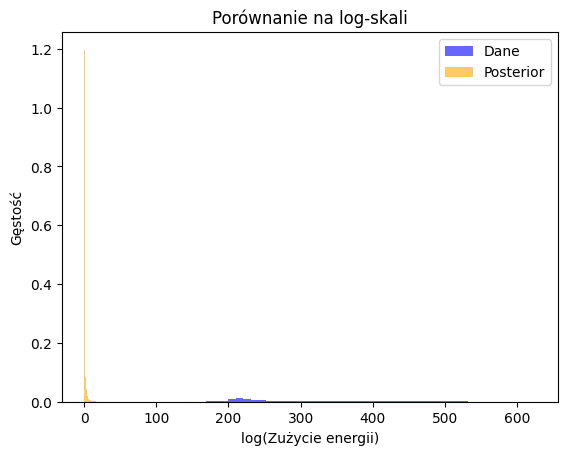

In [ ]:
posterior_all_samples = posterior_all.y_sim.mean(axis=0)

plt.hist(df_subset["energy_consumption"], bins=50, alpha=0.6, label="Dane", color='blue', density=True)
plt.hist(posterior_all_samples, bins=50, alpha=0.6, label="Posterior", color='orange', density=True)
plt.legend()
plt.xlabel("log(Zużycie energii)")
plt.ylabel("Gęstość")

plt.title("Porównanie na log-skali")
plt.show()

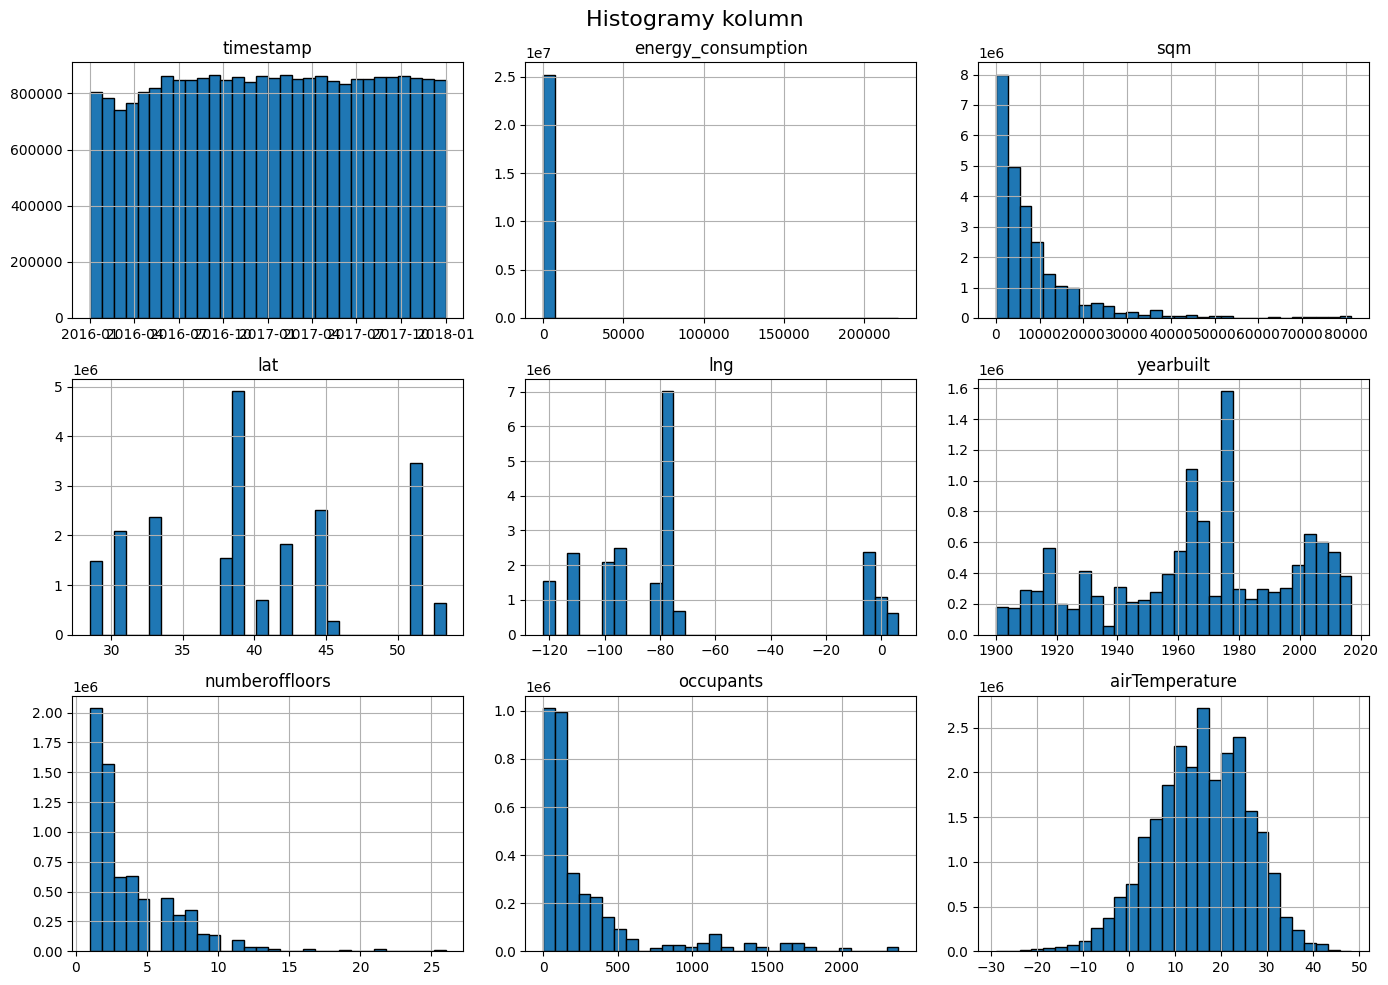

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Zakładam, że df_final jest już przygotowany i zawiera wskazane kolumny

# Histogramy
df_final.hist(
    figsize=(14, 10),
    bins=30,
    edgecolor='black',
    layout=(3, 3)  # 3x3 układ wykresów
)
plt.suptitle('Histogramy kolumn', fontsize=16)
plt.tight_layout()
plt.show()


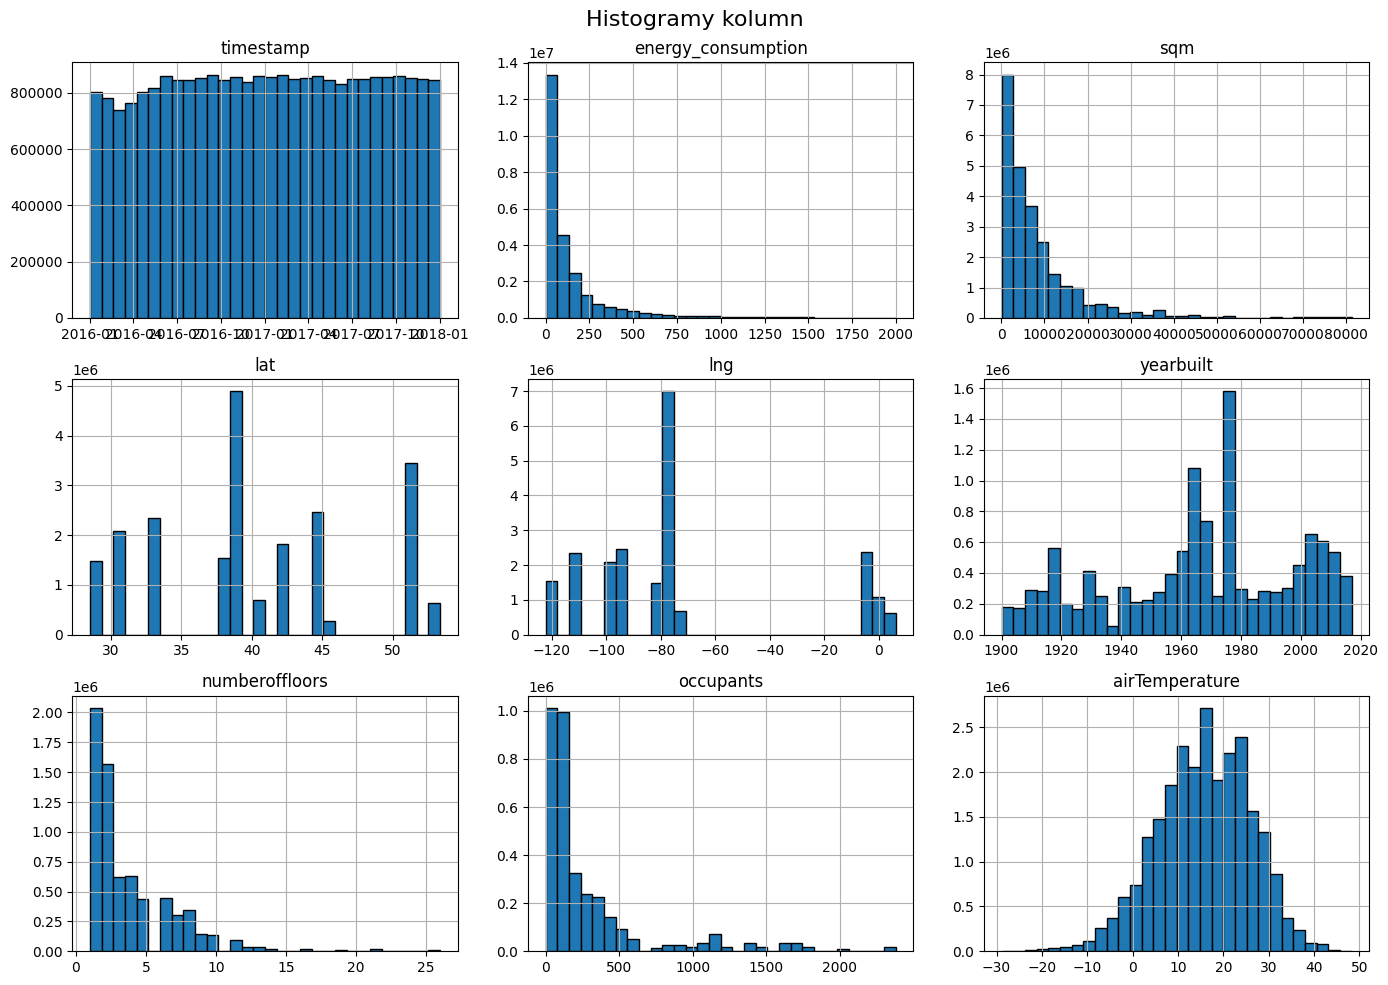

In [ ]:
df_final = df_final[df_final['energy_consumption'] < 2000]

df_final.hist(
    figsize=(14, 10),
    bins=30,
    edgecolor='black',
    layout=(3, 3)  # 3x3 układ wykresów
)

plt.suptitle('Histogramy kolumn', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
df_final

,timestamp,building_id,energy_consumption,site_id,sqm,lat,lng,timezone,industry,yearbuilt,numberoffloors,occupants,airTemperature
0,2016-01-01 00:00:00,Bear_assembly_Angel,237.8500,Bear,22117.0,37.871903,-122.260729,US/Pacific,NaN,1933.0,6.0,NaN,4.4
1,2016-01-01 01:00:00,Bear_assembly_Angel,221.2500,Bear,22117.0,37.871903,-122.260729,US/Pacific,NaN,1933.0,6.0,NaN,4.4
2,2016-01-01 02:00:00,Bear_assembly_Angel,222.5000,Bear,22117.0,37.871903,-122.260729,US/Pacific,NaN,1933.0,6.0,NaN,4.4
3,2016-01-01 03:00:00,Bear_assembly_Angel,221.4000,Bear,22117.0,37.871903,-122.260729,US/Pacific,NaN,1933.0,6.0,NaN,4.4
4,2016-01-01 04:00:00,Bear_assembly_Angel,224.2500,Bear,22117.0,37.871903,-122.260729,US/Pacific,NaN,1933.0,6.0,NaN,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25212574,2017-12-31 19:00:00,Wolf_science_Alfreda,72.4275,Wolf,914.0,53.349800,6.260300,Europe/Dublin,Education,NaN,NaN,NaN,4.4
25212575,2017-12-31 20:00:00,Wolf_science_Alfreda,73.4875,Wolf,914.0,53.349800,6.260300,Europe/Dublin,Education,NaN,NaN,NaN,4.0
25212576,2017-12-31 21:00:00,Wolf_science_Alfreda,72.7675,Wolf,914.0,53.349800,6.260300,Europe/Dublin,Education,NaN,NaN,NaN,4.4
25212577,2017-12-31 22:00:00,Wolf_science_Alfreda,72.5375,Wolf,914.0,53.349800,6.260300,Europe/Dublin,Education,NaN,NaN,NaN,4.2


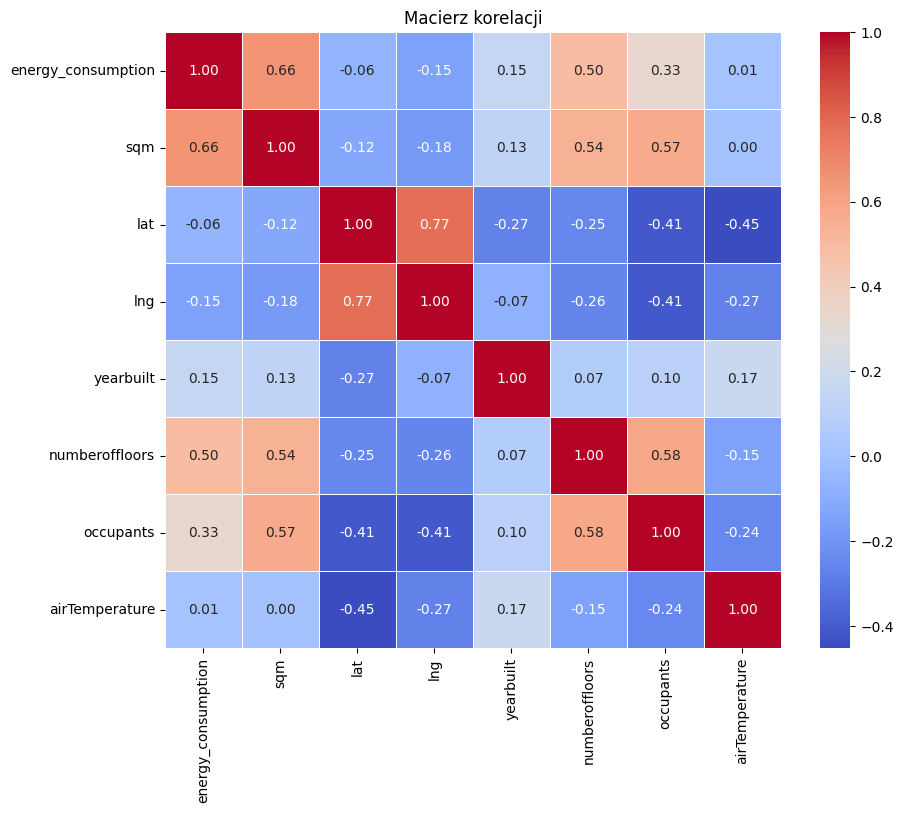

In [ ]:
# Heatmapa korelacji
plt.figure(figsize=(10, 8))
corr_matrix = df_final.drop(columns=['timestamp', 'timezone', 'industry', 'building_id', 'site_id']).corr()  # timestamp nie jest liczbowy
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    square=True,
    linewidths=0.5
)
plt.title('Macierz korelacji')
plt.show()


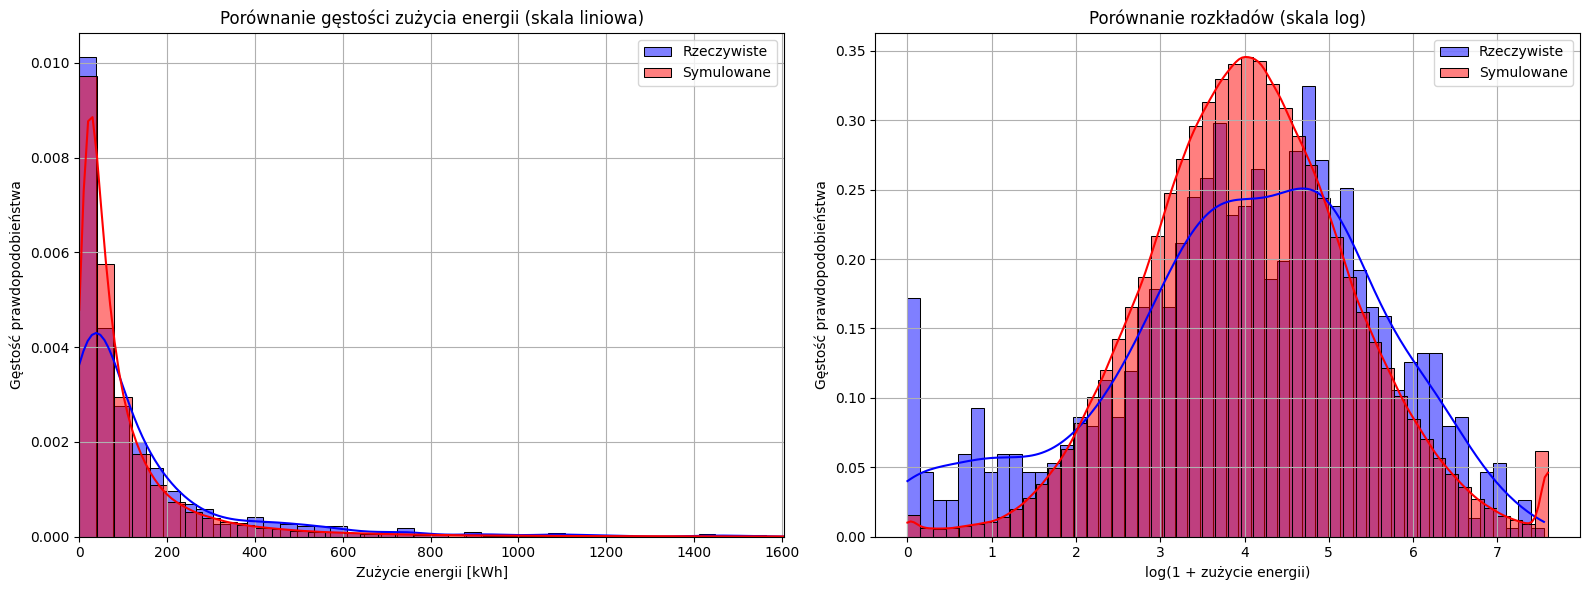

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

# Ustawienia stylu i rozmiaru wykresów
plt.rcParams['figure.figsize'] = (16, 6)

def calculate_density_comparison(real_data, simulated_data, max_points=10000):
    """
    Funkcja obliczająca i porównująca gęstości rozkładów
    """
    # Obliczanie zakresu dla wykresów
    combined_data = np.concatenate([real_data.reshape(-1), simulated_data.reshape(-1)])
    min_val = np.min(combined_data)
    max_val = np.percentile(combined_data, 99.9)
    
    # Obliczanie gęstości
    grid = np.linspace(min_val, max_val, 500)
    kde_real = gaussian_kde(real_data)(grid)
    kde_sim = gaussian_kde(simulated_data)(grid)
    
    return grid, kde_real, kde_sim

def simulate_from_prior(sqm, temp, num_samples=1000):
    log_sqm = np.log1p(sqm)  # Używamy log1p dla bezpieczeństwa
    log_sqm_scaled = (log_sqm - np.mean(log_sqm)) / np.std(log_sqm)
    temp_scaled = (temp - np.mean(temp)) / np.std(temp)
    
    # 2. Optymalne parametry modelu
    beta0 = np.random.normal(4.0, 1, num_samples)  # Średni poziom zużycia
    beta1 = np.random.normal(0.6, 0.1, num_samples)  # Wpływ powierzchni
    beta2 = np.random.normal(-0.4, 0.1, num_samples) # Wpływ temperatury
    sigma = np.random.lognormal(-1, 1, num_samples) # Kontrola rozrzutu
    
    # 3. Generowanie z nieliniowościami
    mu = beta0[:, None] + \
         beta1[:, None] * np.tanh(log_sqm_scaled) + \
         beta2[:, None] * temp_scaled * np.exp(-temp_scaled**2)  # Lokalne ekstremum
    
    # 4. Symulacja z obcięciem ekstremów
    simulated = np.exp(np.random.normal(mu, sigma[:, None]))
    simulated = np.minimum(simulated, 2000)  # Obcięcie ekstremalnych wartości
    
    return simulated.flatten()

# Przygotowanie danych
sample_size = 1000
clean_data = df_final[["energy_consumption", "sqm", "airTemperature"]].dropna()

# Pobranie próbki zachowującej relacje między kolumnami
if len(clean_data) > sample_size:
    real_sample = clean_data.sample(n=sample_size, random_state=42)
else:
    real_sample = clean_data.copy()

# Wydzielenie kolumn
real_energy = real_sample["energy_consumption"].values
sqm = real_sample["sqm"].values
temp = real_sample["airTemperature"].values

# Generowanie symulowanych danych
simulated_data = simulate_from_prior(sqm, temp)

# Tworzenie wykresów
fig, (ax1, ax2) = plt.subplots(1, 2)

# Wykres 1: Skala liniowa
sns.histplot(real_energy, bins=50, color='blue', alpha=0.5, 
             label='Rzeczywiste', ax=ax1, stat='density', kde=True)
sns.histplot(simulated_data, bins=50, color='red', alpha=0.5, 
             label='Symulowane', ax=ax1, stat='density', kde=True)
ax1.set_title('Porównanie gęstości zużycia energii (skala liniowa)')
ax1.set_xlabel('Zużycie energii [kWh]')
ax1.set_ylabel('Gęstość prawdopodobieństwa')
ax1.legend()
ax1.grid(True)

# Ustawienie limitu osi X
combined = np.concatenate([real_energy, simulated_data])
ax1.set_xlim(0, np.percentile(combined, 99))

# Wykres 2: Skala logarytmiczna
log_real = np.log1p(real_energy)
log_sim = np.log1p(simulated_data)

sns.histplot(log_real, bins=50, color='blue', alpha=0.5, 
             label='Rzeczywiste', ax=ax2, stat='density', kde=True)
sns.histplot(log_sim, bins=50, color='red', alpha=0.5, 
             label='Symulowane', ax=ax2, stat='density', kde=True)
ax2.set_title('Porównanie rozkładów (skala log)')
ax2.set_xlabel('log(1 + zużycie energii)')
ax2.set_ylabel('Gęstość prawdopodobieństwa')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


### Modele

In [ ]:
# Zakładamy, że mamy kolumnę np. "energy"
# df_subset = df_final[['airTemperature', 'sqm', "energy_consumption", 'building_id']].dropna()
df_subset = df_final[['airTemperature', 'sqm', "energy_consumption", 'building_id']].dropna()

# Creating models
N = 1000
df_subset = df_subset.iloc[:N]

model_prior = CmdStanModel(stan_file='prior.stan')

temp = df_subset['airTemperature']
sqm	= df_subset['sqm']

# Setting data
data = {'N': N, 'temp': temp, 'sqm': sqm}

# Sampling z priora
prior_1 = model_prior.sample(
    data=data,
    iter_sampling=1000,
    iter_warmup=1,
    chains=1,
    fixed_param=True,
    seed=29042020,
    refresh=100,
)

# Odczyt wyników
prior_df = prior_1.draws_pd()
prior_df.head()


19:39:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

19:39:50 - cmdstanpy - INFO - CmdStan done processing.


,chain__,iter__,draw__,lp__,accept_stat__,y_sim[1],y_sim[2],y_sim[3],y_sim[4],y_sim[5],...,y_sim[991],y_sim[992],y_sim[993],y_sim[994],y_sim[995],y_sim[996],y_sim[997],y_sim[998],y_sim[999],y_sim[1000]
0,1.0,1.0,1.0,0.0,0.0,18.2306,130.6490,89.56860,3.88526,38.2604,...,13.66450,31.39600,9.06094,173.8660,21.3261,28.10650,87.70250,67.09730,227.36200,13.1518
1,1.0,2.0,2.0,0.0,0.0,167.8940,36.4005,4.02263,19.65160,167.2460,...,51.21240,18.87990,104.68100,17.4832,19.7931,198.74900,7.92320,37.36930,28.15620,22.1944
2,1.0,3.0,3.0,0.0,0.0,86.5892,39.4192,9.07939,128.70900,13.4720,...,8.61097,14.74400,771.93900,13.2922,12.8327,3.51578,1.00469,4.99077,1.23859,36.0713
3,1.0,4.0,4.0,0.0,0.0,304.3570,30.6559,1.16798,6.15168,18.1759,...,45.76390,173.27300,358.66200,24.3251,53.2726,14.06890,41.81450,42.05300,72.20480,22.7367
4,1.0,5.0,5.0,0.0,0.0,10.8035,126.0200,18.68860,60.54010,174.2690,...,25.41660,7.83591,5.33729,13.6639,76.3213,138.82700,16.52000,125.01900,20.72780,30.6335


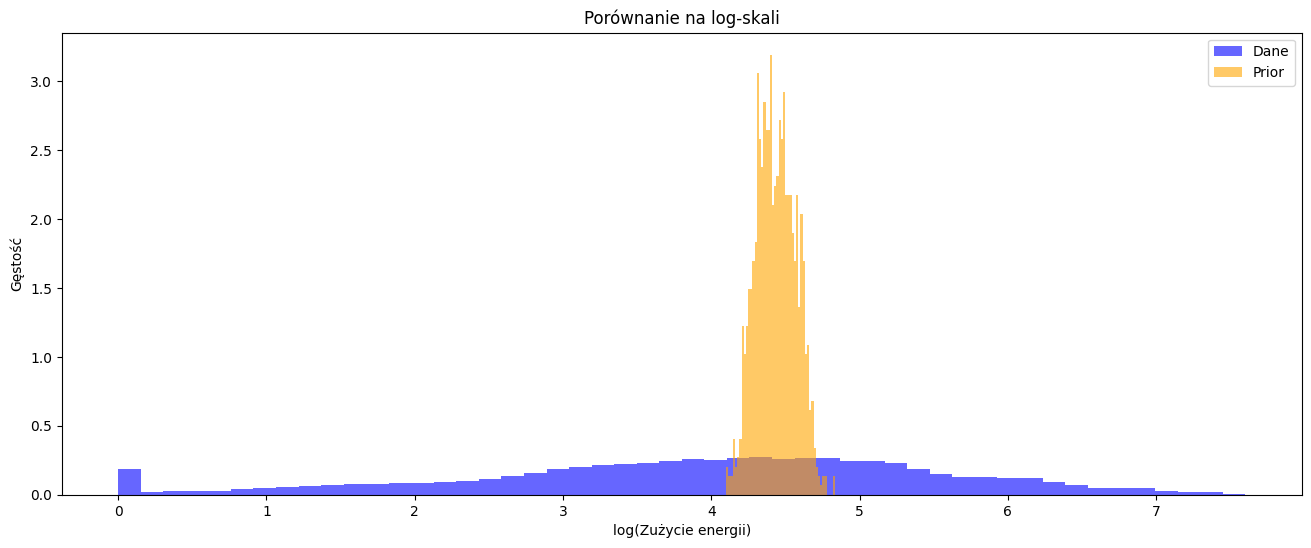

In [ ]:
prior_samples = prior_1.y_sim.mean(axis=0)

plt.hist(np.log1p(df_final["energy_consumption"]), bins=50, alpha=0.6, label="Dane", color='blue', density=True)
plt.hist(np.log1p(prior_samples), bins=50, alpha=0.6, label="Prior", color='orange', density=True)
plt.legend()
plt.xlabel("log(Zużycie energii)")
plt.ylabel("Gęstość")
plt.title("Porównanie na log-skali")
plt.show()

In [ ]:
prior_df.describe()

,chain__,iter__,draw__,lp__,accept_stat__,y_sim[1],y_sim[2],y_sim[3],y_sim[4],y_sim[5],...,y_sim[991],y_sim[992],y_sim[993],y_sim[994],y_sim[995],y_sim[996],y_sim[997],y_sim[998],y_sim[999],y_sim[1000]
count,1000.0,1000.000000,1000.000000,1000.0,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1.000000e+03,1000.000000
mean,1.0,500.500000,500.500000,0.0,0.0,92.428428,79.297930,78.191295,72.917060,78.382305,...,88.195634,74.132588,82.040077,83.702632,76.774689,84.023827,8.356787e+01,94.507305,8.541127e+01,87.008266
std,0.0,288.819436,288.819436,0.0,0.0,235.639467,187.027712,181.890540,160.436405,191.858580,...,216.178580,200.997185,232.003353,200.839770,169.322034,191.178932,2.206388e+02,245.310838,1.996451e+02,229.890035
min,1.0,1.000000,1.000000,0.0,0.0,0.001117,0.001474,0.000285,0.000002,0.012443,...,0.019949,0.001052,0.004769,0.039566,0.016882,0.000168,3.395090e-07,0.007048,5.244040e-07,0.000615
25%,1.0,250.750000,250.750000,0.0,0.0,14.994225,15.339150,15.355925,15.510075,14.956600,...,15.100475,11.437225,14.245350,14.617275,14.762525,16.357475,1.624383e+01,15.968700,1.686633e+01,15.462975
50%,1.0,500.500000,500.500000,0.0,0.0,34.343750,34.560750,35.574400,35.276000,33.795250,...,36.297850,26.937150,31.320150,32.231050,31.665850,35.488350,3.304095e+01,35.002950,3.485205e+01,31.588850
75%,1.0,750.250000,750.250000,0.0,0.0,81.955675,78.164900,77.954750,71.542950,76.040025,...,77.548025,60.365900,67.611100,72.791125,71.036125,77.916575,7.596740e+01,77.531100,7.547770e+01,69.745550
max,1.0,1000.000000,1000.000000,0.0,0.0,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2.000000e+03,2000.000000,2.000000e+03,2000.000000


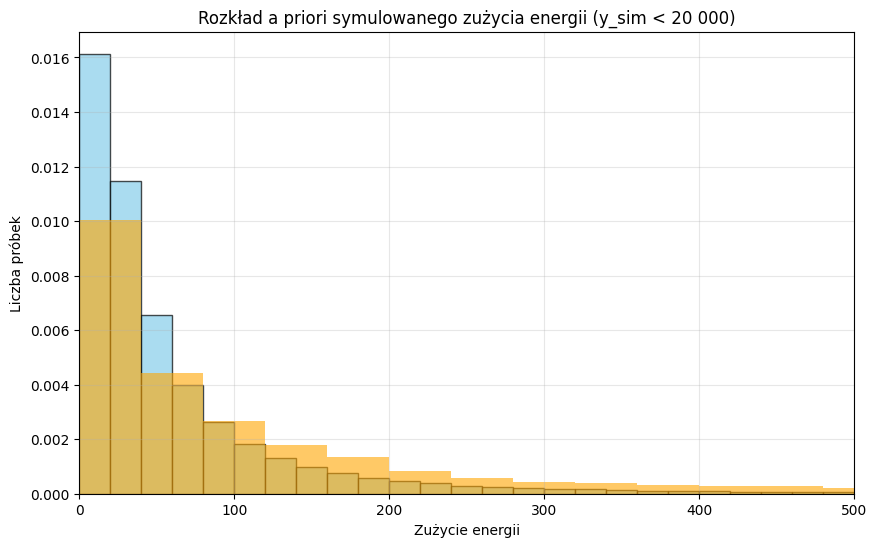

In [ ]:
y_sim_columns = [col for col in prior_df.columns if col.startswith('y_sim')]

# Spłaszcz wszystkie próbki do jednej tablicy
prior_samples = np.concatenate([prior_df[col].values for col in y_sim_columns])

# Narysuj histogram
plt.figure(figsize=(10, 6))
plt.hist(prior_samples, bins=100, color='skyblue', edgecolor='black', alpha=0.7, density=True)
plt.hist(df_final["energy_consumption"], bins=50, alpha=0.6, label="Prior", color='orange', density=True)
plt.title('Rozkład a priori symulowanego zużycia energii (y_sim < 20 000)')
plt.xlabel('Zużycie energii')
plt.ylabel('Liczba próbek')
plt.xlim(0, 500)  # Ustawienie limitu osi X

plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
az.summary(prior_1)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
y_sim[0],92.428,235.639,0.001,247.303,7.401,25.918,910.0,976.0,NaN
y_sim[1],79.298,187.028,0.001,235.226,6.177,28.260,971.0,952.0,NaN
y_sim[2],78.191,181.891,0.000,212.947,5.659,25.446,975.0,983.0,NaN
y_sim[3],72.917,160.436,0.000,207.570,4.992,23.766,899.0,950.0,NaN
y_sim[4],78.382,191.859,0.012,201.563,6.674,28.477,971.0,905.0,NaN
...,...,...,...,...,...,...,...,...,...
y_sim[995],84.024,191.179,0.000,246.801,6.072,23.286,704.0,949.0,NaN
y_sim[996],83.568,220.639,0.000,176.271,7.136,26.061,978.0,942.0,NaN
y_sim[997],94.507,245.311,0.007,256.035,7.994,25.982,849.0,843.0,NaN
y_sim[998],85.411,199.645,0.000,244.181,6.639,23.769,980.0,823.0,NaN


In [ ]:
data = {'N': N, 'temp': df_subset['airTemperature'], 'sqm': df_subset['sqm'], 'y': df_subset['energy_consumption']}
model_posterior = CmdStanModel(stan_file='posterior.stan')
post_1 = model_posterior.sample(data=data, chains=1, iter_sampling=1000)

# Odczyt wyników
posterior_df = post_1.draws_pd()
posterior_df.head()

19:39:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

19:40:01 - cmdstanpy - INFO - CmdStan done processing.


,chain__,iter__,draw__,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,...,log_lik[991],log_lik[992],log_lik[993],log_lik[994],log_lik[995],log_lik[996],log_lik[997],log_lik[998],log_lik[999],log_lik[1000]
0,1.0,1.0,1.0,353.172,0.978945,0.115238,5.0,47.0,0.0,-351.894,...,-55.0629,-61.6056,-61.7880,-58.1910,-58.1700,-56.6414,-56.6528,-54.9708,-56.4825,-55.7048
1,1.0,2.0,2.0,353.193,0.977489,0.115238,5.0,31.0,0.0,-348.892,...,-61.0846,-66.9347,-67.0819,-63.8323,-63.8091,-62.4217,-62.4345,-60.9110,-62.2458,-61.4833
2,1.0,3.0,3.0,354.894,0.990706,0.115238,5.0,47.0,0.0,-352.382,...,-59.8377,-65.5603,-65.7043,-62.5254,-62.5028,-61.1456,-61.1580,-59.6678,-60.9734,-60.2274
3,1.0,4.0,4.0,356.507,0.946720,0.115238,5.0,31.0,0.0,-352.859,...,-53.4492,-58.3542,-58.4751,-55.7445,-55.7244,-54.5578,-54.5689,-53.2886,-54.4047,-53.7544
4,1.0,5.0,5.0,356.709,0.970964,0.115238,2.0,3.0,0.0,-356.070,...,-54.3760,-59.3814,-59.5053,-56.7204,-56.7000,-55.5103,-55.5215,-54.2156,-55.3553,-54.6942


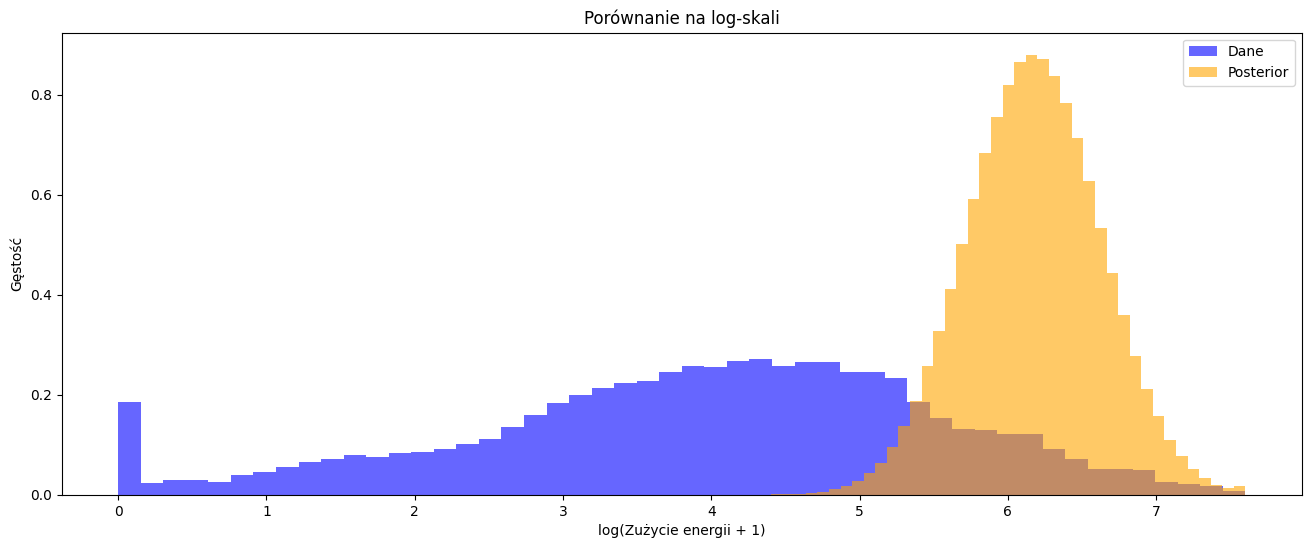

In [ ]:
posterior_samples = post_1.y_sim.flatten()

plt.hist(np.log1p(df_final["energy_consumption"]), bins=50, alpha=0.6, label="Dane", color='blue', density=True)
plt.hist(np.log1p(posterior_samples), bins=50, alpha=0.6, label="Posterior", color='orange', density=True)
plt.legend()
plt.xlabel("log(Zużycie energii + 1)")
plt.ylabel("Gęstość")
plt.title("Porównanie na log-skali")
plt.show()

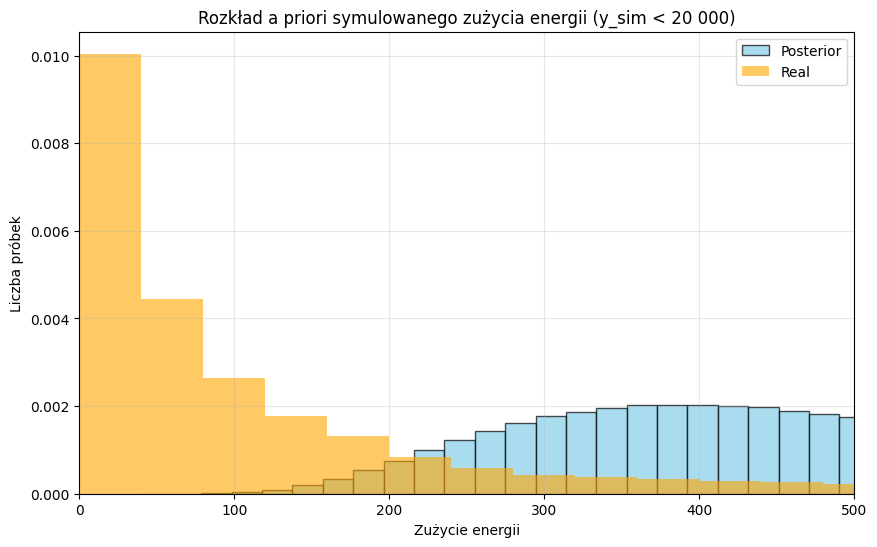

In [ ]:
y_sim_columns = [col for col in posterior_df.columns if col.startswith('y_sim')]

# Spłaszcz wszystkie próbki do jednej tablicy
posterior_samples = np.concatenate([posterior_df[col].values for col in y_sim_columns])

# Narysuj histogram
plt.figure(figsize=(10, 6))
plt.hist(posterior_samples, bins=100, color='skyblue', label="Posterior", edgecolor='black', alpha=0.7, density=True)
plt.hist(df_final["energy_consumption"], bins=50, alpha=0.6, label="Real", color='orange', density=True)
plt.title('Rozkład a priori symulowanego zużycia energii (y_sim < 20 000)')
plt.xlabel('Zużycie energii')
plt.ylabel('Liczba próbek')
plt.xlim(0, 500)  # Ustawienie limitu osi X
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
az.summary(post_1)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,6.619,0.089,6.459,6.785,0.004,0.003,389.0,470.0,NaN
beta1,0.774,0.150,0.523,1.077,0.007,0.005,401.0,392.0,NaN
beta2,0.398,0.029,0.343,0.450,0.001,0.001,639.0,562.0,NaN
sigma,0.417,0.009,0.398,0.433,0.000,0.000,706.0,519.0,NaN
y_sim[0],496.370,218.726,153.740,857.074,6.953,7.586,1005.0,908.0,NaN
...,...,...,...,...,...,...,...,...,...
mu[995],6.227,0.013,6.204,6.256,0.000,0.000,841.0,557.0,NaN
mu[996],6.227,0.013,6.204,6.256,0.000,0.000,841.0,557.0,NaN
mu[997],6.169,0.013,6.144,6.193,0.000,0.000,997.0,722.0,NaN
mu[998],6.227,0.013,6.204,6.256,0.000,0.000,841.0,557.0,NaN


In [ ]:
df_test = df_final[df_final['building_id'] == "Bear_assembly_Angel"]
df_test

,timestamp,building_id,energy_consumption,site_id,sqm,lat,lng,timezone,industry,yearbuilt,numberoffloors,occupants,airTemperature
0,2016-01-01 00:00:00,Bear_assembly_Angel,237.8500,Bear,22117.0,37.871903,-122.260729,US/Pacific,NaN,1933.0,6.0,NaN,4.4
1,2016-01-01 01:00:00,Bear_assembly_Angel,221.2500,Bear,22117.0,37.871903,-122.260729,US/Pacific,NaN,1933.0,6.0,NaN,4.4
2,2016-01-01 02:00:00,Bear_assembly_Angel,222.5000,Bear,22117.0,37.871903,-122.260729,US/Pacific,NaN,1933.0,6.0,NaN,4.4
3,2016-01-01 03:00:00,Bear_assembly_Angel,221.4000,Bear,22117.0,37.871903,-122.260729,US/Pacific,NaN,1933.0,6.0,NaN,4.4
4,2016-01-01 04:00:00,Bear_assembly_Angel,224.2500,Bear,22117.0,37.871903,-122.260729,US/Pacific,NaN,1933.0,6.0,NaN,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14430,2017-12-31 19:00:00,Bear_assembly_Angel,319.2544,Bear,22117.0,37.871903,-122.260729,US/Pacific,NaN,1933.0,6.0,NaN,11.1
14431,2017-12-31 20:00:00,Bear_assembly_Angel,313.7506,Bear,22117.0,37.871903,-122.260729,US/Pacific,NaN,1933.0,6.0,NaN,11.1
14432,2017-12-31 21:00:00,Bear_assembly_Angel,309.0006,Bear,22117.0,37.871903,-122.260729,US/Pacific,NaN,1933.0,6.0,NaN,9.4
14433,2017-12-31 22:00:00,Bear_assembly_Angel,284.5062,Bear,22117.0,37.871903,-122.260729,US/Pacific,NaN,1933.0,6.0,NaN,9.4


SEZONOWOŚĆ


In [ ]:
# Przykładowe dane czasowe
df_seasonal = df_final[:1000]
df_seasonal['hour'] = df_seasonal['timestamp'].dt.hour
df_seasonal['day_of_week'] = df_seasonal['timestamp'].dt.dayofweek

model_prior_seasonal = CmdStanModel(stan_file='prior_seasonal.stan')

data = {
    'N': len(df_seasonal),
    'sqm': df_seasonal['sqm'].values,
    'temp': df_seasonal['airTemperature'].values,
    'hour': df_seasonal['hour'].values,
    'day_of_week': df_seasonal['day_of_week'].values
}

# Sampling z priora
prior_1_seasonal = model_prior_seasonal.sample(
    data=data,
    iter_sampling=1000,
    iter_warmup=1,
    chains=1,
    fixed_param=True,
    seed=29042020,
    refresh=100,
)

# Odczyt wyników
prior_seasonal_df = prior_1_seasonal.draws_pd()
prior_seasonal_df.head()



C:\Users\Julia\AppData\Local\Temp\ipykernel_22332\1745398565.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seasonal['hour'] = df_seasonal['timestamp'].dt.hour
C:\Users\Julia\AppData\Local\Temp\ipykernel_22332\1745398565.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seasonal['day_of_week'] = df_seasonal['timestamp'].dt.dayofweek
19:40:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

19:40:10 - cmdstanpy - INFO - CmdStan done processing.


,chain__,iter__,draw__,lp__,accept_stat__,y_sim[1],y_sim[2],y_sim[3],y_sim[4],y_sim[5],...,y_sim[991],y_sim[992],y_sim[993],y_sim[994],y_sim[995],y_sim[996],y_sim[997],y_sim[998],y_sim[999],y_sim[1000]
0,1.0,1.0,1.0,0.0,0.0,81.6728,1.53398,70.25850,4.49958,5.45921,...,21.1156,91.4328,48.145500,31.20050,98.74180,33.31160,160.373000,96.2355,14.17520,37.6296
1,1.0,2.0,2.0,0.0,0.0,126.0760,6.97639,2.68712,47.95520,203.64500,...,22.9796,88.5331,35.115200,173.42600,2000.00000,19.31140,9.876230,17.2079,22.88040,133.2000
2,1.0,3.0,3.0,0.0,0.0,43.9150,26.40420,18.05410,134.78800,38.45110,...,60.8487,46.2133,7.407750,8.70024,6.81049,39.89520,12.427000,324.8200,66.94150,36.5062
3,1.0,4.0,4.0,0.0,0.0,70.7956,9.12563,3.64323,69.48740,12.45760,...,6.2547,22.1394,187.098000,70.87310,9.88913,3.23701,0.001127,3.4043,2.19355,22.5118
4,1.0,5.0,5.0,0.0,0.0,50.2247,46.28950,13.50000,235.33700,13.14490,...,56.6980,19.6038,0.945627,159.45200,40.31430,53.26550,75.677600,84.2310,23.86480,37.2489


In [ ]:
model_posterior_seasonal = CmdStanModel(stan_file='posterior_seasonal.stan')

data = {
    'N': len(df_seasonal),
    'sqm': df_seasonal['sqm'].values,
    'temp': df_seasonal['airTemperature'].values,
    'hour': df_seasonal['hour'].values,
    'day_of_week': df_seasonal['day_of_week'].values,
    'y': df_seasonal['energy_consumption'].values
}

# Sampling z priora
posterior_1_seasonal = model_posterior_seasonal.sample(
    data=data, chains=1, iter_sampling=1000
)

# Odczyt wyników
posterior_seasonal_df = posterior_1_seasonal.draws_pd()
posterior_seasonal_df.head()

19:40:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

19:40:27 - cmdstanpy - INFO - CmdStan done processing.
19:40:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'posterior_seasonal.stan', line 61, column 4 to column 32)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'posterior_seasonal.stan', line 61, column 4 to column 32)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'posterior_seasonal.stan', line 61, column 4 to column 32)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'posterior_seasonal.stan', line 61, column 4 to column 32)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'posterior_seasonal.stan', line 61, column 4 to column 32)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'posterior_seasonal.stan', line 61, column 4 to column 32)
	Exception: logn

,chain__,iter__,draw__,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,...,log_lik[991],log_lik[992],log_lik[993],log_lik[994],log_lik[995],log_lik[996],log_lik[997],log_lik[998],log_lik[999],log_lik[1000]
0,1.0,1.0,1.0,-68.1868,0.916177,0.084905,5.0,31.0,0.0,69.4432,...,-7.78815,-7.17636,-6.76491,-6.58767,-6.42184,-6.38812,-6.36417,-6.40838,-6.65379,-7.43619
1,1.0,2.0,2.0,-69.1227,0.880608,0.084905,5.0,31.0,0.0,71.5606,...,-7.77305,-7.19309,-6.75986,-6.56832,-6.40486,-6.37175,-6.34865,-6.38537,-6.60876,-7.35120
2,1.0,3.0,3.0,-70.8528,0.946863,0.084905,5.0,31.0,0.0,73.2933,...,-7.63576,-7.09533,-6.68680,-6.51389,-6.38114,-6.36213,-6.34765,-6.37279,-6.55605,-7.22326
3,1.0,4.0,4.0,-65.4345,0.827938,0.084905,5.0,47.0,0.0,73.7956,...,-7.69321,-6.96574,-6.63004,-6.51083,-6.36447,-6.34354,-6.32656,-6.38102,-6.65909,-7.53792
4,1.0,5.0,5.0,-65.5995,0.985942,0.084905,6.0,63.0,0.0,67.6836,...,-7.80716,-7.12045,-6.73463,-6.57944,-6.41512,-6.38482,-6.36319,-6.41823,-6.69613,-7.55412


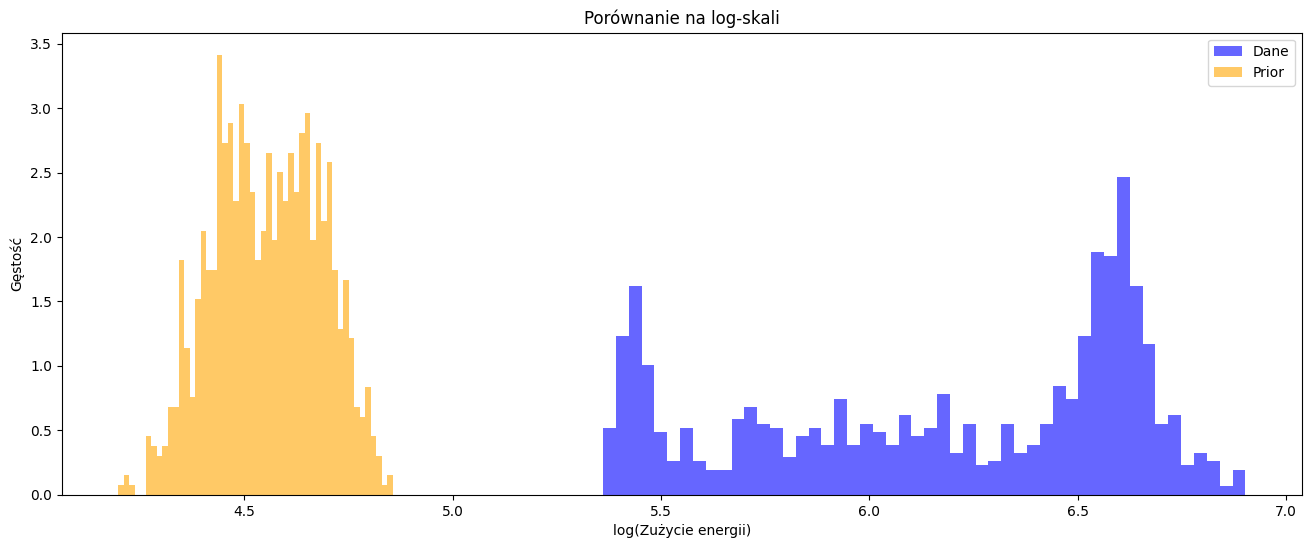

In [ ]:
prior_samples = prior_1_seasonal.y_sim.mean(axis=0)

plt.hist(np.log1p(df_seasonal["energy_consumption"]), bins=50, alpha=0.6, label="Dane", color='blue', density=True)
plt.hist(np.log1p(prior_samples), bins=50, alpha=0.6, label="Prior", color='orange', density=True)
plt.legend()
plt.xlabel("log(Zużycie energii)")
plt.ylabel("Gęstość")
plt.title("Porównanie na log-skali")
plt.show()

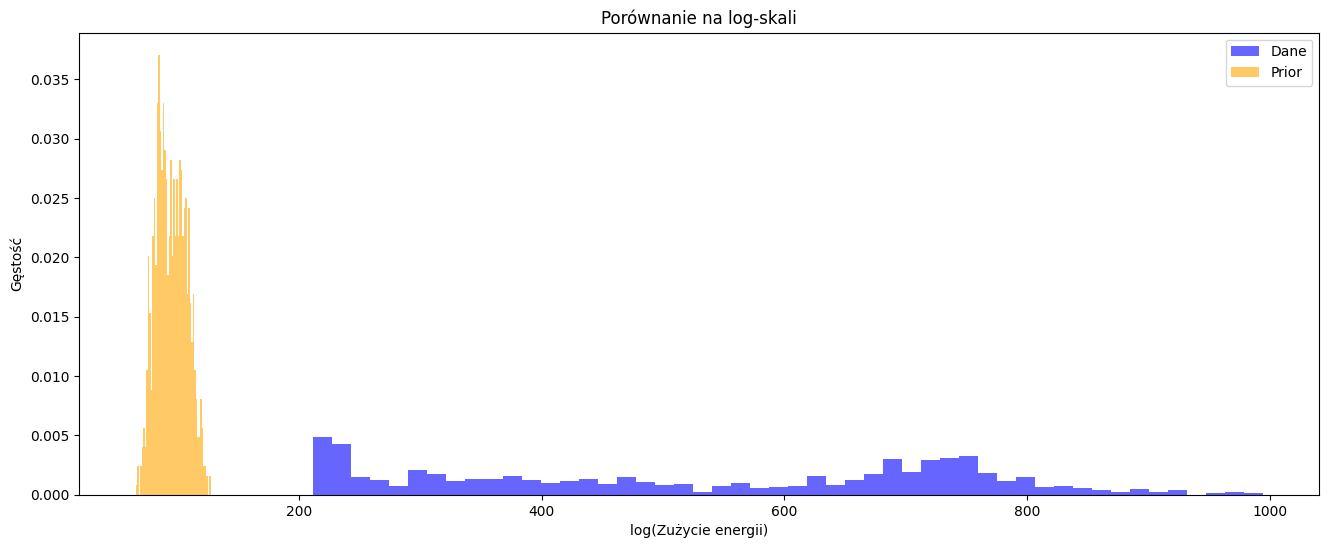

In [ ]:
prior_samples = prior_1_seasonal.y_sim.mean(axis=0)

plt.hist(df_seasonal["energy_consumption"], bins=50, alpha=0.6, label="Dane", color='blue', density=True)
plt.hist(prior_samples, bins=50, alpha=0.6, label="Prior", color='orange', density=True)
plt.legend()
plt.xlabel("log(Zużycie energii)")
plt.ylabel("Gęstość")
plt.title("Porównanie na log-skali")
plt.show()

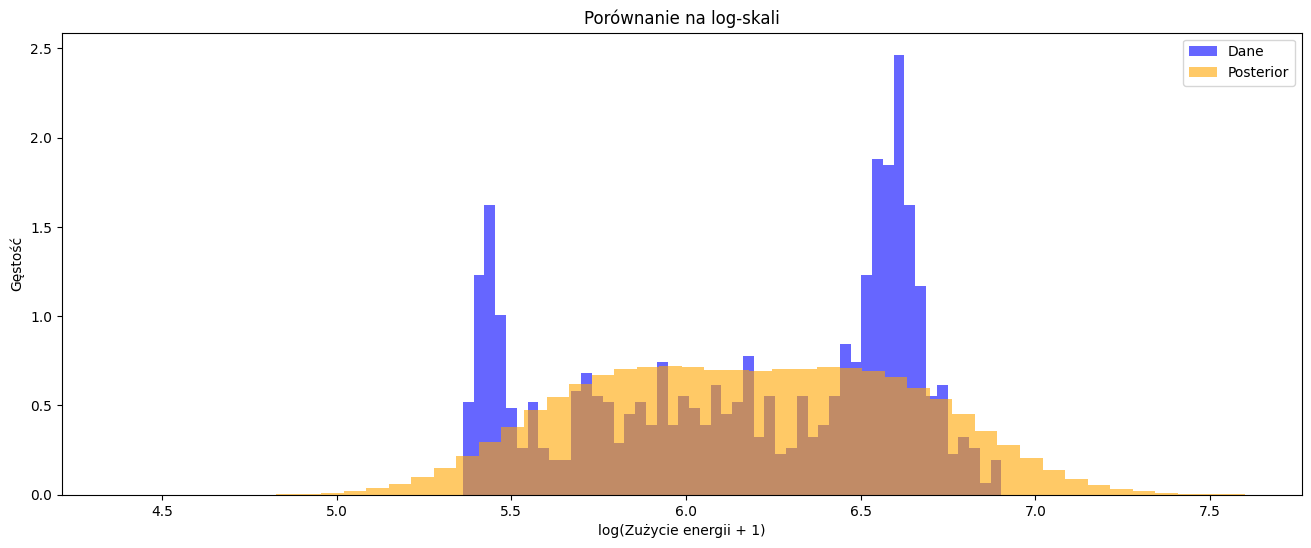

In [ ]:
posterior_samples = posterior_1_seasonal.y_sim.flatten()

plt.hist(np.log1p(df_seasonal["energy_consumption"]), bins=50, alpha=0.6, label="Dane", color='blue', density=True)
plt.hist(np.log1p(posterior_samples), bins=50, alpha=0.6, label="Posterior", color='orange', density=True)
plt.legend()
plt.xlabel("log(Zużycie energii + 1)")
plt.ylabel("Gęstość")
plt.title("Porównanie na log-skali")
plt.show()

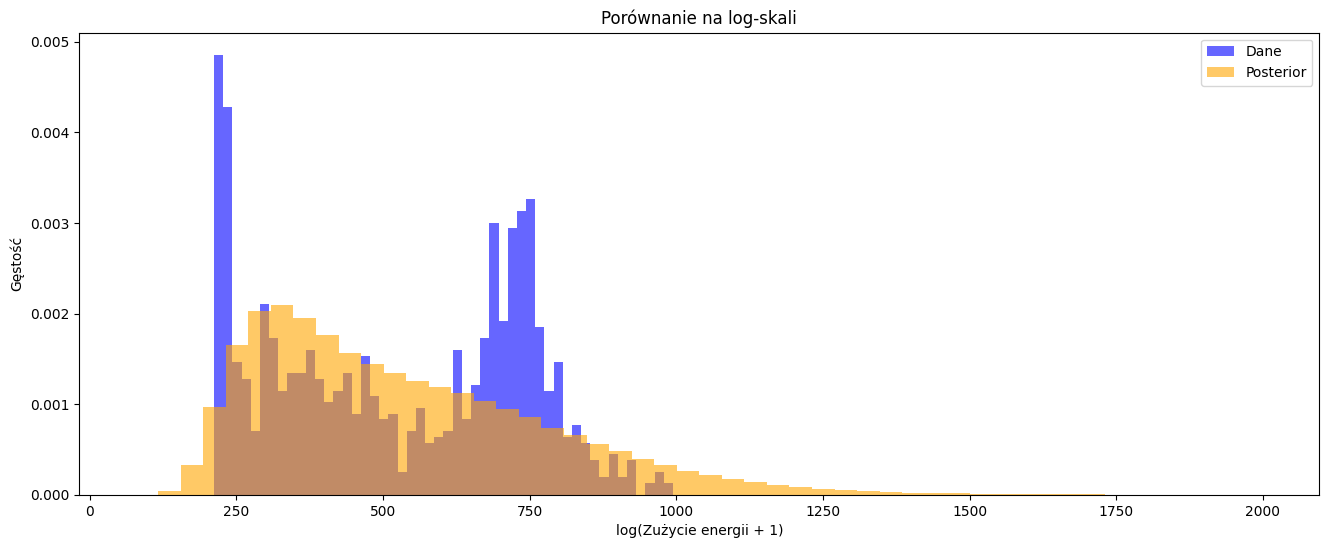

In [ ]:
posterior_samples = posterior_1_seasonal.y_sim.flatten()

plt.hist(df_seasonal["energy_consumption"], bins=50, alpha=0.6, label="Dane", color='blue', density=True)
plt.hist(posterior_samples, bins=50, alpha=0.6, label="Posterior", color='orange', density=True)
plt.legend()
plt.xlabel("log(Zużycie energii + 1)")
plt.ylabel("Gęstość")
plt.title("Porównanie na log-skali")
plt.show()

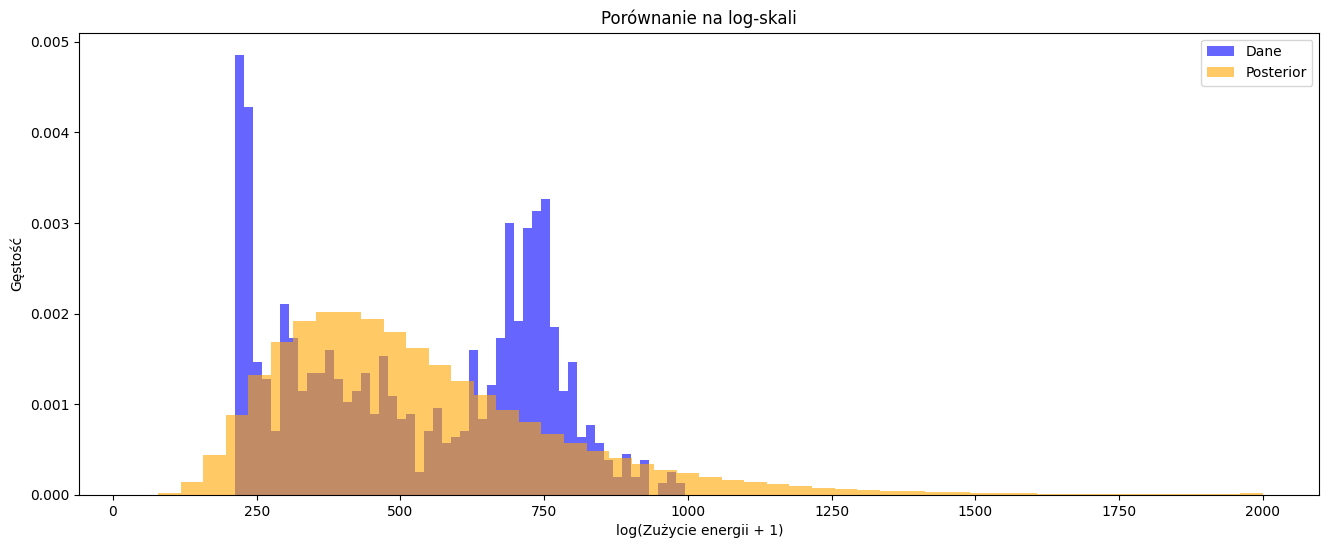

In [ ]:
posterior_samples = post_1.y_sim.flatten()

plt.hist(df_seasonal["energy_consumption"], bins=50, alpha=0.6, label="Dane", color='blue', density=True)
plt.hist(posterior_samples, bins=50, alpha=0.6, label="Posterior", color='orange', density=True)
plt.legend()
plt.xlabel("log(Zużycie energii + 1)")
plt.ylabel("Gęstość")
plt.title("Porównanie na log-skali")
plt.show()

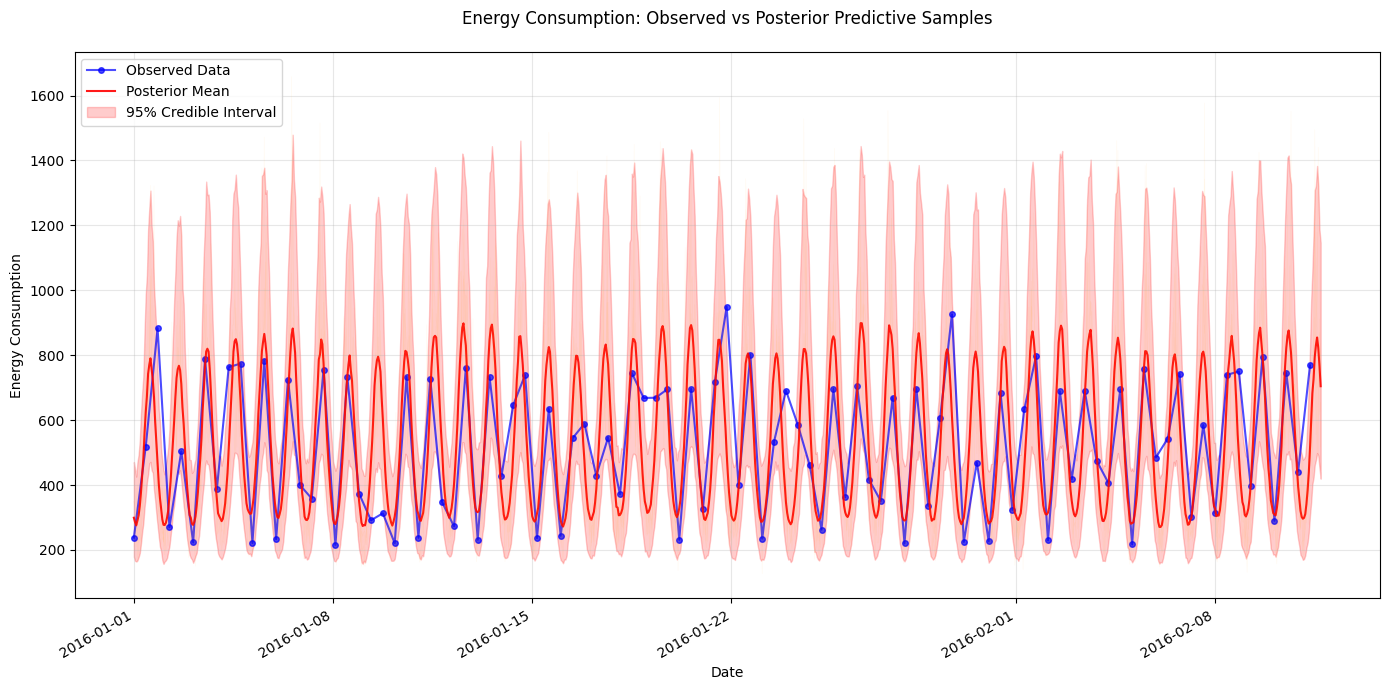

In [ ]:
# Prepare data
dates = df_seasonal['timestamp'].values # Assuming your df_seasonal has timestamps
observed = df_seasonal["energy_consumption"].values
simulated = posterior_1_seasonal.y_sim  # Shape: (samples, observations)

# Calculate statistics
mean_sim = np.mean(simulated, axis=0)
upper_95 = np.percentile(simulated, 97.5, axis=0)
lower_95 = np.percentile(simulated, 2.5, axis=0)

# Create time series plot
plt.figure(figsize=(14, 7))

# Plot observed data (every 10th point for clarity)
plt.plot(dates[::10], observed[::10], 
         color='blue', alpha=0.7, label='Observed Data', 
         linewidth=1.5, marker='o', markersize=4)

# Plot posterior predictive
plt.plot(dates, mean_sim, color='red', 
         alpha=0.9, label='Posterior Mean')
plt.fill_between(dates, lower_95, upper_95, 
                color='red', alpha=0.2, 
                label='95% Credible Interval')

# Plot some individual posterior samples
for i in range(0, 1000, 200):  # Plot every 200th sample
    plt.plot(dates, simulated[i], 
             color='orange', alpha=0.05, 
             linewidth=0.5)

# Formatting
plt.title('Energy Consumption: Observed vs Posterior Predictive Samples', pad=20)
plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.legend(loc='upper left')

# Improve x-axis for dates
plt.gcf().autofmt_xdate()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

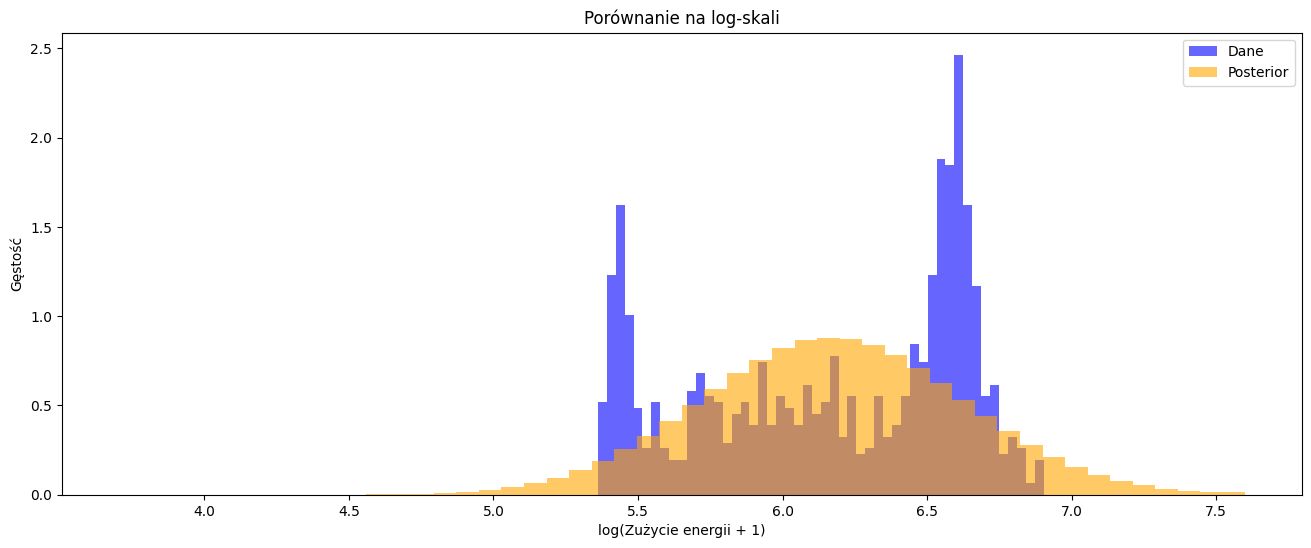

In [ ]:
posterior_samples = post_1.y_sim.flatten()

plt.hist(np.log1p(df_seasonal["energy_consumption"]), bins=50, alpha=0.6, label="Dane", color='blue', density=True)
plt.hist(np.log1p(posterior_samples), bins=50, alpha=0.6, label="Posterior", color='orange', density=True)
plt.legend()
plt.xlabel("log(Zużycie energii + 1)")
plt.ylabel("Gęstość")
plt.title("Porównanie na log-skali")
plt.show()

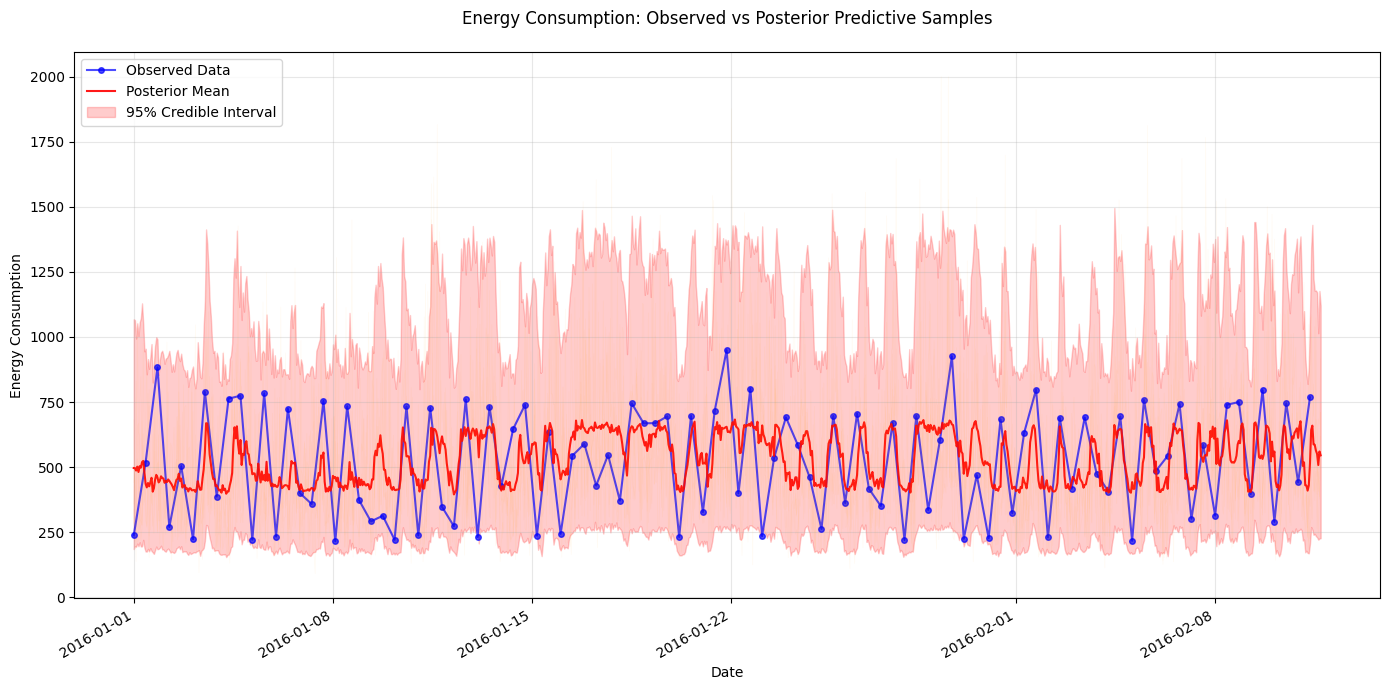

In [ ]:
# Prepare data
dates = df_seasonal['timestamp'].values # Assuming your df_seasonal has timestamps
observed = df_seasonal["energy_consumption"].values
simulated = post_1.y_sim  # Shape: (samples, observations)

# Calculate statistics
mean_sim = np.mean(simulated, axis=0)
upper_95 = np.percentile(simulated, 97.5, axis=0)
lower_95 = np.percentile(simulated, 2.5, axis=0)

# Create time series plot
plt.figure(figsize=(14, 7))

# Plot observed data (every 10th point for clarity)
plt.plot(dates[::10], observed[::10], 
         color='blue', alpha=0.7, label='Observed Data', 
         linewidth=1.5, marker='o', markersize=4)

# Plot posterior predictive
plt.plot(dates, mean_sim, color='red', 
         alpha=0.9, label='Posterior Mean')
plt.fill_between(dates, lower_95, upper_95, 
                color='red', alpha=0.2, 
                label='95% Credible Interval')

# Plot some individual posterior samples
for i in range(0, 1000, 200):  # Plot every 200th sample
    plt.plot(dates, simulated[i], 
             color='orange', alpha=0.05, 
             linewidth=0.5)

# Formatting
plt.title('Energy Consumption: Observed vs Posterior Predictive Samples', pad=20)
plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.legend(loc='upper left')

# Improve x-axis for dates
plt.gcf().autofmt_xdate()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Generacja próbek

19:40:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

19:40:31 - cmdstanpy - INFO - CmdStan done processing.




Wynik prognozy zużycia energii:
- Aktualna temperatura: 4.4°C
- Powierzchnia: 22117 m²
- Przewidywane zużycie energii: 487.4 kWh
- 95% przedział niepewności: (162.1, 1055.2) kWh


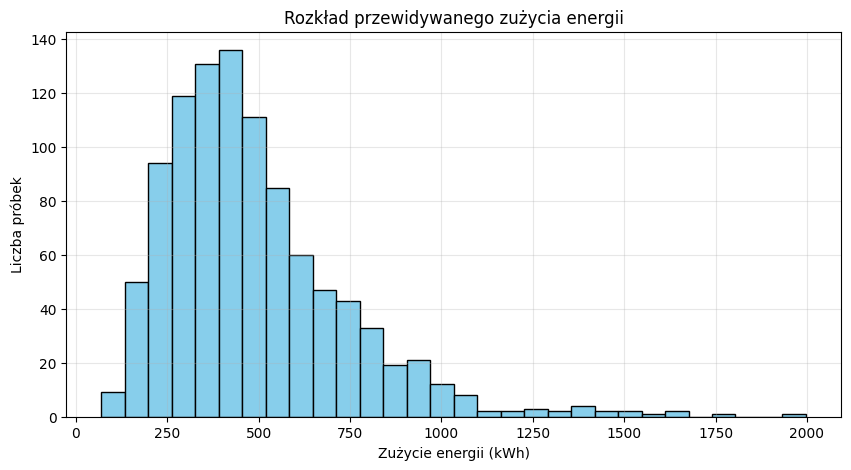

In [ ]:
# 1. Wczytanie danych historycznych
df_subset = df_test[['airTemperature', 'sqm', 'energy_consumption']].dropna().copy()

N = 100
df_subset = df_subset.iloc[:N]

# 2. Przygotowanie danych dla modelu
data = {
    'N': len(df_subset),
    'temp': df_subset['airTemperature'].values.astype(float),
    'sqm': df_subset['sqm'].values.astype(float),
    'y': df_subset['energy_consumption'].values.astype(float)
}

# 3. Wczytanie modelu
model = CmdStanModel(stan_file='posterior.stan')

# 4. Pobranie aktualnych danych (tutaj przykładowe wartości - zastąp rzeczywistymi)
current_temp = 4.4
current_sqm = 22117

# 5. Przygotowanie danych predykcyjnych
pred_data = data.copy()
pred_data['temp'] = np.append(data['temp'][-99:], current_temp)
pred_data['sqm'] = np.append(data['sqm'][-99:], current_sqm)
pred_data['N'] = len(pred_data['temp'])

# 6. Generowanie prognozy
fit = model.sample(data=pred_data, chains=1, iter_sampling=1000)
y_sim = fit.stan_variable('y_sim')[:, -1]

# 7. Analiza wyników
print("\nWynik prognozy zużycia energii:")
print(f"- Aktualna temperatura: {current_temp}°C")
print(f"- Powierzchnia: {current_sqm} m²")
print(f"- Przewidywane zużycie energii: {np.mean(y_sim):.1f} kWh")
print(f"- 95% przedział niepewności: ({np.percentile(y_sim, 2.5):.1f}, {np.percentile(y_sim, 97.5):.1f}) kWh")

# 8. Wizualizacja rozkładu prognozy (opcjonalnie)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.hist(y_sim, bins=30, color='skyblue', edgecolor='black')
plt.title('Rozkład przewidywanego zużycia energii')
plt.xlabel('Zużycie energii (kWh)')
plt.ylabel('Liczba próbek')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
import arviz as az

posterior_idata = az.from_cmdstanpy(
    posterior=post_1,
    posterior_predictive="y_sim"
)

posterior_seasonal_idata = az.from_cmdstanpy(
    posterior=posterior_1_seasonal,
    posterior_predictive="y_sim"
)

posterior_idata = az.from_cmdstanpy(
    posterior=posterior_1_seasonal,
    posterior_predictive="y_sim",
    log_likelihood='log_lik'  
)

loo_result = az.loo(posterior_seasonal_idata)
waic_result = az.waic(posterior_seasonal_idata)

print("LOO:", loo_result)
print("WAIC:", waic_result)

LOO: Computed from 1000 posterior samples and 1000 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -6227.31    28.15
p_loo        7.05        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.67]   (good)     1000  100.0%
   (0.67, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

WAIC: Computed from 1000 posterior samples and 1000 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -6227.27    28.15
p_waic        7.01        -


In [ ]:
compare_dict = {
        "Posterior Seasonal": posterior_1_seasonal,
        "Posterior": post_1,
        "Posterior All": posterior_all,
    }
compare_df =az.compare(compare_dict)

# Narysuj wykres porównawczy
az.plot_compare(compare_df, figsize=(10, 4), plot_ic_diff=True, insample_dev=False)
plt.show()

c:\Users\Julia\Desktop\Praca_magisterska\SmartIO\BAYESIAN\.venv\Lib\site-packages\arviz\stats\stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.67 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\Users\Julia\Desktop\Praca_magisterska\SmartIO\BAYESIAN\.venv\Lib\site-packages\arviz\stats\stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.67 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


ValueError: The number of observations should be the same across all models

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cmdstanpy import CmdStanModel

# 1. Ustawienia ogólne
sqm_value = 22117  # stała powierzchnia
np.random.seed(42)

# 2. Generowanie daty i czasu co godzinę dla stycznia 2025
date_range = pd.date_range(start="2025-01-01", end="2025-03-31 23:00:00", freq="H")
N = len(date_range)

df_seasonal = building_data.dropna(subset=['airTemperature', 'energy_consumption']).copy()
df_seasonal['hour'] = df_seasonal['timestamp'].dt.hour
df_seasonal['day_of_week'] = df_seasonal['timestamp'].dt.dayofweek

# 4. Wydobycie cech czasowych
hours = df_seasonal['timestamp'].dt.hour
days_of_week = df_seasonal['timestamp'].dt.dayofweek



# 5. Przygotowanie danych do predykcji
pred_data = {
    'N': len(df_seasonal),
    'temp': df_seasonal['airTemperature'],
    'sqm': df_seasonal['sqm'],
    'hour': hours,
    'day_of_week': days_of_week,
    'y': df_seasonal['energy_consumption']
}

# 6. Wczytanie modelu
model = CmdStanModel(stan_file='posterior_seasonal.stan')

# 7. Próbkowanie
fit = model.sample(data=pred_data, chains=1, iter_sampling=1000)
y_sim = fit.stan_variable('y_sim')  # shape: (1000, N)

# 8. Obliczenie średnich predykcji i przedziałów niepewności
y_mean = np.mean(y_sim, axis=0)
y_lower = np.percentile(y_sim, 2.5, axis=0)
y_upper = np.percentile(y_sim, 97.5, axis=0)



C:\Users\Julia\AppData\Local\Temp\ipykernel_9572\512743494.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start="2025-01-01", end="2025-03-31 23:00:00", freq="H")
23:47:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

23:47:57 - cmdstanpy - INFO - CmdStan done processing.
23:47:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'posterior_seasonal.stan', line 61, column 4 to column 32)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'posterior_seasonal.stan', line 61, column 4 to column 32)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'posterior_seasonal.stan', line 61, column 4 to column 32)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'posterior_seasonal.stan', line 61, column 4 to column 32)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'posterior_seasonal.stan', line 61, column 4 to column 32)
Consider re-running with show_console=True if the above output is unclear!


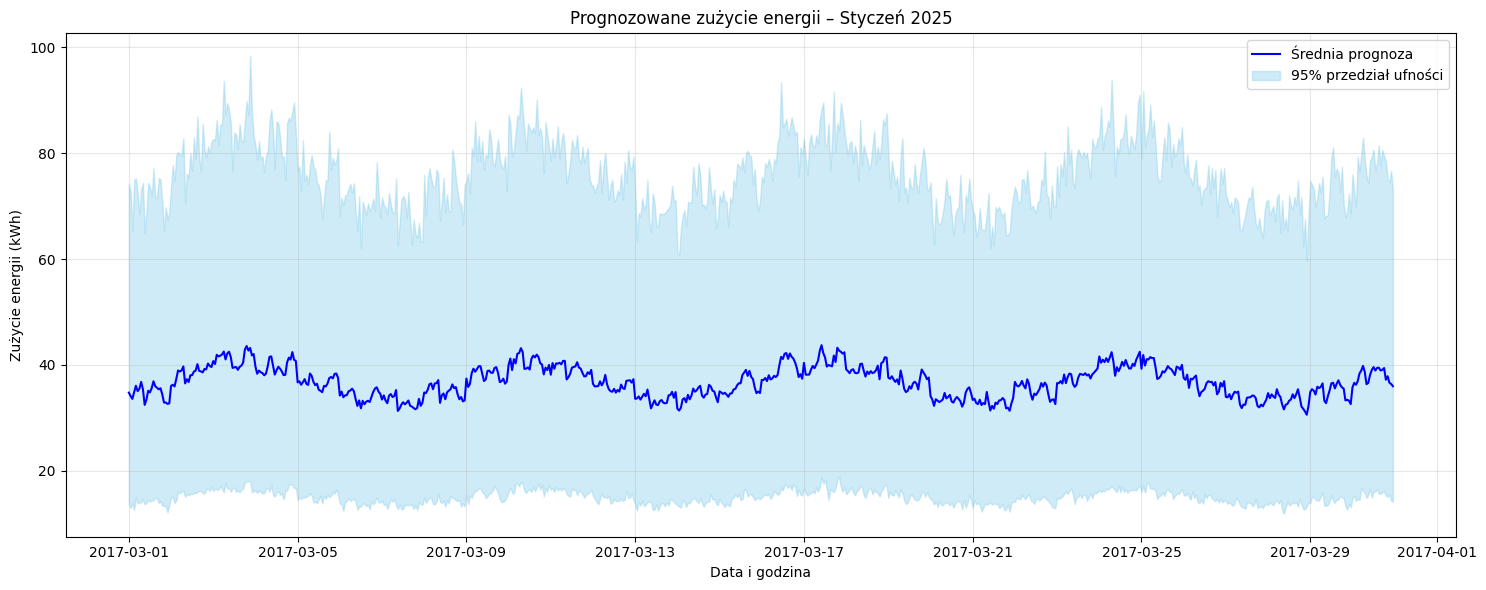

In [ ]:
# 9. Tworzenie wykresu liniowego
plt.figure(figsize=(15, 6))
plt.plot(df_seasonal['timestamp'], y_mean, label="Średnia prognoza", color="blue")
plt.fill_between(df_seasonal['timestamp'], y_lower, y_upper, color="skyblue", alpha=0.4, label="95% przedział ufności")
plt.title("Prognozowane zużycie energii – Styczeń 2025")
plt.xlabel("Data i godzina")
plt.ylabel("Zużycie energii (kWh)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


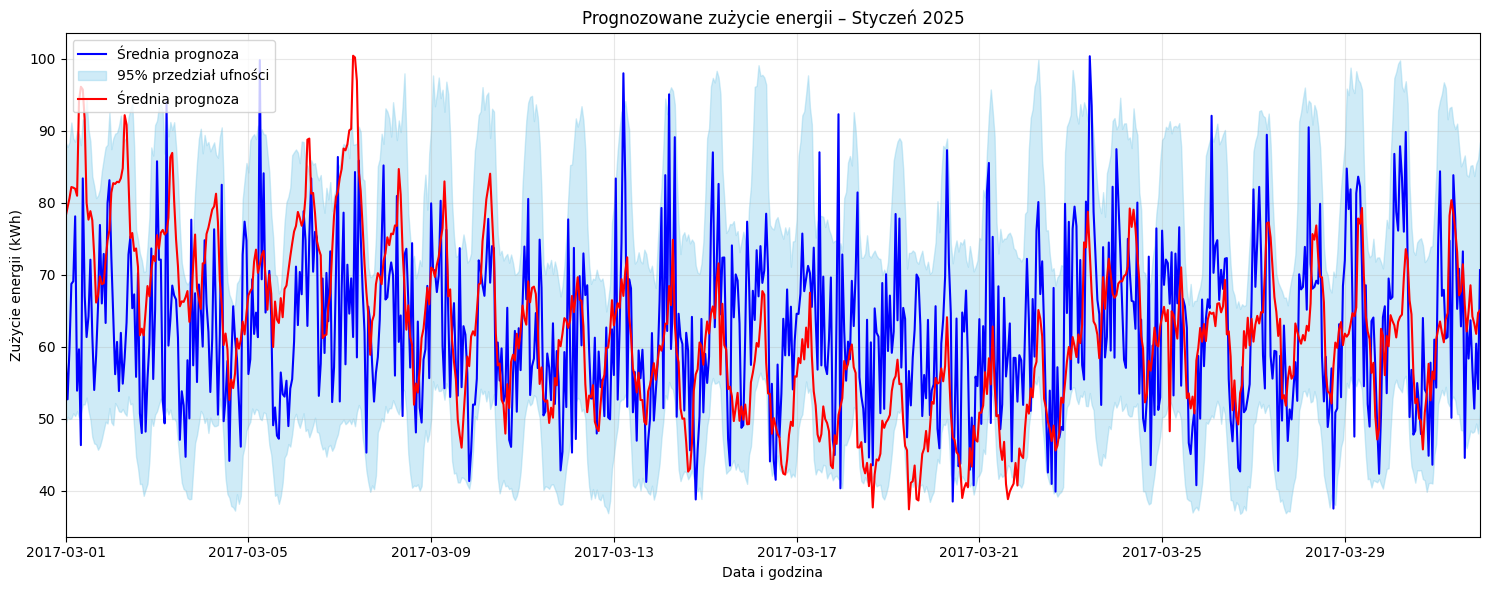

In [ ]:
# 9. Tworzenie wykresu liniowego
plt.figure(figsize=(15, 6))
plt.plot(df_seasonal['timestamp'], y_sim[0], label="Średnia prognoza", color="blue")
plt.fill_between(df_seasonal['timestamp'], y_lower, y_upper, color="skyblue", alpha=0.4, label="95% przedział ufności")
plt.plot(df_seasonal['timestamp'], df_seasonal['energy_consumption'], label="Średnia prognoza", color="red")
plt.title("Prognozowane zużycie energii – Styczeń 2025")
plt.xlabel("Data i godzina")
plt.ylabel("Zużycie energii (kWh)")
plt.xlim(df_seasonal['timestamp'].min(), df_seasonal['timestamp'].max())
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
